In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
sns.set_style(style = 'darkgrid')

In [2]:
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

**Project Objective:**

- The main objective of this study is to create a suitable model based on the avilable historical Walmart weekly sales data and forecast the weekly sales and create a visualizations to discover hidden patterns or trends in the data.
- The visualizations creates compares the findings from exploratory data analysis. 

**Data Description:**
- The historical data is availiable from 45 stores located in different regions around the country.
- The data has been collected from Intellipaat as an assignment and contains the weekly sales for 45 stores.
- An additional information is available in the dataset about the factors that might influence the sales of a particular week.
- These factors have been recorded each week to analyze if there is a significant dependence between weekly sales and the factors to develop a statistical model. The factors are, whether the week is holiday week or not, temperature, fuel price, Consumer Price Index (CPI), and unemployment rate.


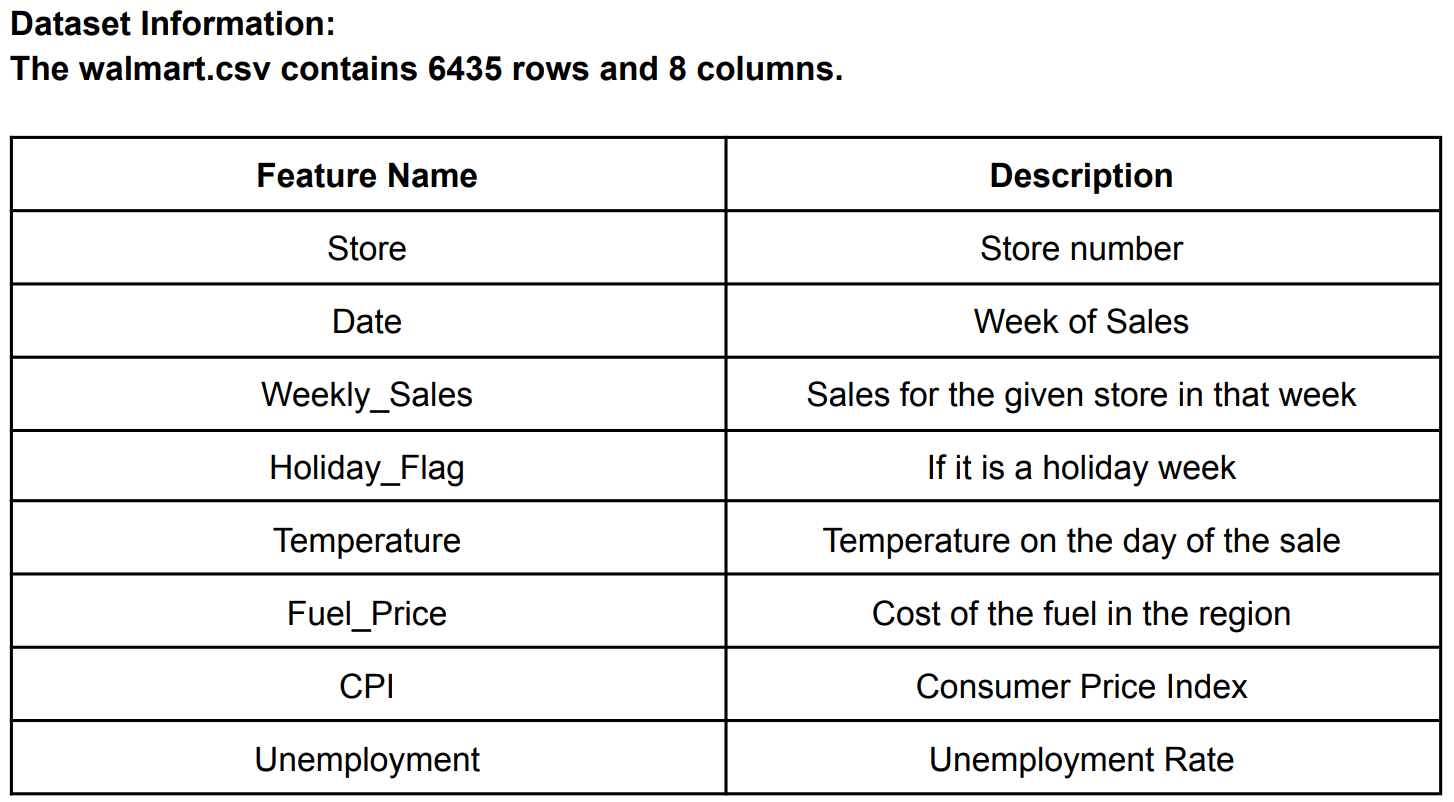


**Methodology:**
- This particular study comprises of several different components that explore various aspecr od the 45 Walmart stores used in the study.
- Milestones for the study is as follows:
    * Data Cleaning and Pre-processing
    * Exploratory Data Analysis
    * Statistical Data Analysis
    * Modeling and Evaluation
    * Conclusion

## Data Loading

In [3]:
df = pd.read_csv("Walmart DataSet.csv",  # file_name
                 parse_dates= ['Date'],  # parse 'Date' column as a Datetime datatype
                 dayfirst= True,         # format of date has 1st value day
                 index_col='Date')       # set index as 'Date'
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


## Data Preprocessing

- In this section, we will find out if any null values are present or no. Similarly, we will find if any duplicated observations are present or not.
- Since the data is time series data, we cannot delete any observations based on null values, since the order of thime series is of importance to forecast the wekkly sales value. Therefore we will focus on imputation if any null values are present.
- However, duplicate records can be deleted.

In [5]:
##checking for null value count
pd.DataFrame(df.isnull().sum(), columns = ['Count'])

,Count
Store,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [10]:
##checking for duplicated records
print(f"Do any Duplicated Records are present? --> {df.duplicated().any()}")

Do any Duplicated Records are present? --> False


In [11]:
##checking storewise data 
df.loc[df['Store'] == 1]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...
2012-09-28,1,1437059.26,0,76.08,3.666,222.981658,6.908
2012-10-05,1,1670785.97,0,68.55,3.617,223.181477,6.573
2012-10-12,1,1573072.81,0,62.99,3.601,223.381296,6.573


In [12]:
df['Weekly_Sales'].describe()

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64

In [13]:
cols = ['Weekly_Sales','Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for col in cols:
    print(df[col].describe())

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64
count    6435.000000
mean       60.663782
std        18.444933
min        -2.060000
25%        47.460000
50%        62.670000
75%        74.940000
max       100.140000
Name: Temperature, dtype: float64
count    6435.000000
mean        3.358607
std         0.459020
min         2.472000
25%         2.933000
50%         3.445000
75%         3.735000
max         4.468000
Name: Fuel_Price, dtype: float64
count    6435.000000
mean      171.578394
std        39.356712
min       126.064000
25%       131.735000
50%       182.616521
75%       212.743293
max       227.232807
Name: CPI, dtype: float64
count    6435.000000
mean        7.999151
std         1.875885
min         3.879000
25%         6.891000
50%         7.874000
75%         8.622000
max        14.313000
Name: Unemployment, dtyp

**Observations:**
- Neither missing values nor duplicated records are present in the dataset.
- For each store data is recorded from '2010-02-05' to '2012-10-26'.
- Every store has 143 observations corresponding to the each week of the year for 2010-2012.

## Feature Engineering

- For Exploratory Data Analysis we will require additional columns such as 'Year', 'Month' and 'Week no' of the recorded datatpoint.
- In this section I have added thoese additional columns to ease our exploratory data analysis.
- To extract the information about month, year or week number from the recorded date, Python's calander module is used.

In [14]:
import calendar
df['Week'] = pd.DatetimeIndex(df.index).week       #Extract week number of the date and store in column 'Week'
df['Month'] = pd.DatetimeIndex(df.index).month     #Extract month number of the date and store in column 'month'
df['Year'] = pd.DatetimeIndex(df.index).year       #Extract year of the recorded date and store in column'year'
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year
Date,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010


- For Exploratory Data Analysis we will follow two approaches, one approach will deal with overvall view and another approach deal with the individual store.
- To deal with the overall view we requires the combined weekly sales across all the stores. To achieve this I have summed up weekly sales values on each date for all stores.
- The resulted data is of 143 records.

In [15]:
np.round(df.loc[df.index == '2010-02-05']['Weekly_Sales'].sum(), 2) ## total weekly sales on the date '2010-02-05'

49750740.5

- 49750740.5 ==> represents the total sales from all 45 stores on date '2010-02-05'.

In [16]:
## droping irrelevant columns (since we are summing up across each store store number,weekly sale, ... of store is rrelevant)
total_df = df[0:143].drop(columns= ['Weekly_Sales','Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']) 
##compute total weekly sales across each store on each date and storing in new column 'Total_Sales'
total_df['Total_Sales'] = df.groupby(by = df.index)['Weekly_Sales'].sum()
total_df.head()

,Holiday_Flag,Week,Month,Year,Total_Sales
Date,,,,,
2010-02-05,0,5,2,2010,49750740.50
2010-02-12,1,6,2,2010,48336677.63
2010-02-19,0,7,2,2010,48276993.78
2010-02-26,0,8,2,2010,43968571.13
2010-03-05,0,9,3,2010,46871470.30


## Exploratory Data Analysis
### Part 1

In [17]:
##summary statistics for 'Total Sales'
total_df['Total_Sales'].describe()

count    1.430000e+02
mean     4.711342e+07
std      5.444206e+06
min      3.959985e+07
25%      4.488059e+07
50%      4.624390e+07
75%      4.779202e+07
max      8.093142e+07
Name: Total_Sales, dtype: float64

**Observations:**
- The average of total sales from all the 45 stores, is 47 million with standard deviation +/- 5 million.
- The median total sales is 46 million. mean and median are parted by small value compared to standard deviation. It implies that the total sales is normally distributed around the mean.

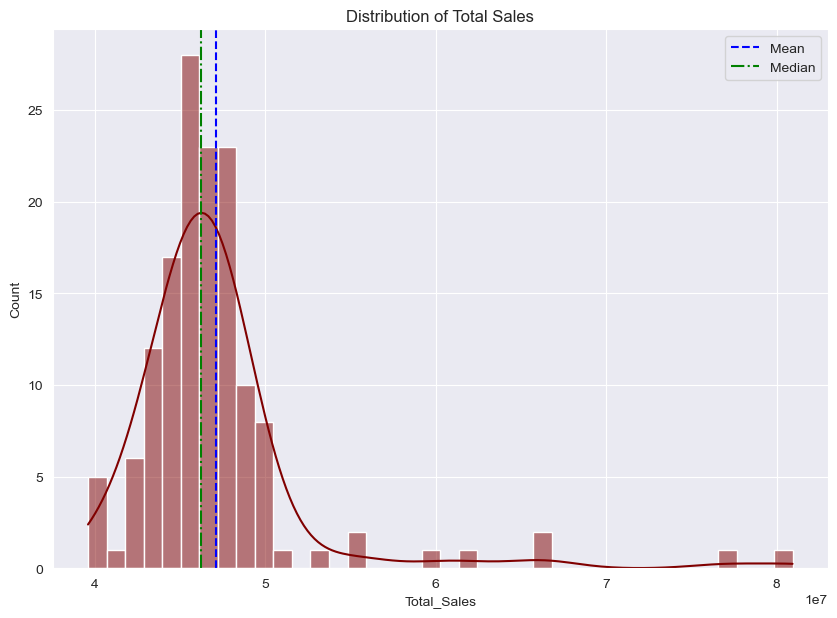

In [18]:
##checking distribution of total sales
plt.subplots(figsize = (10,7))
sns.histplot(data = total_df, x = 'Total_Sales', kde = True, color= 'maroon')
plt.axvline(x = total_df['Total_Sales'].mean(), linestyle ='--', label = 'Mean', color = 'blue')
plt.axvline(x = total_df['Total_Sales'].median(), linestyle ='-.', label = 'Median', color = 'green')
plt.title("Distribution of Total Sales")
plt.legend()
plt.show()

- The slight difference between mean and median is visisble in the distribution. This difference is due to the presence of higher total sales compared to rest of the sales values.

In [19]:
## analysing monthly trend

month_pivot = pd.pivot_table(total_df, values = 'Total_Sales',
              columns = 'Year',
              index = 'Month')
month_pivot.head()

Year,2010,2011,2012
Month,,,
1,NaN,4.092599e+07,4.222362e+07
2,4.758325e+07,4.658283e+07,4.801589e+07
3,4.547995e+07,4.483911e+07,4.630193e+07
4,4.628247e+07,4.530530e+07,4.723023e+07
5,4.667773e+07,4.541204e+07,4.719162e+07


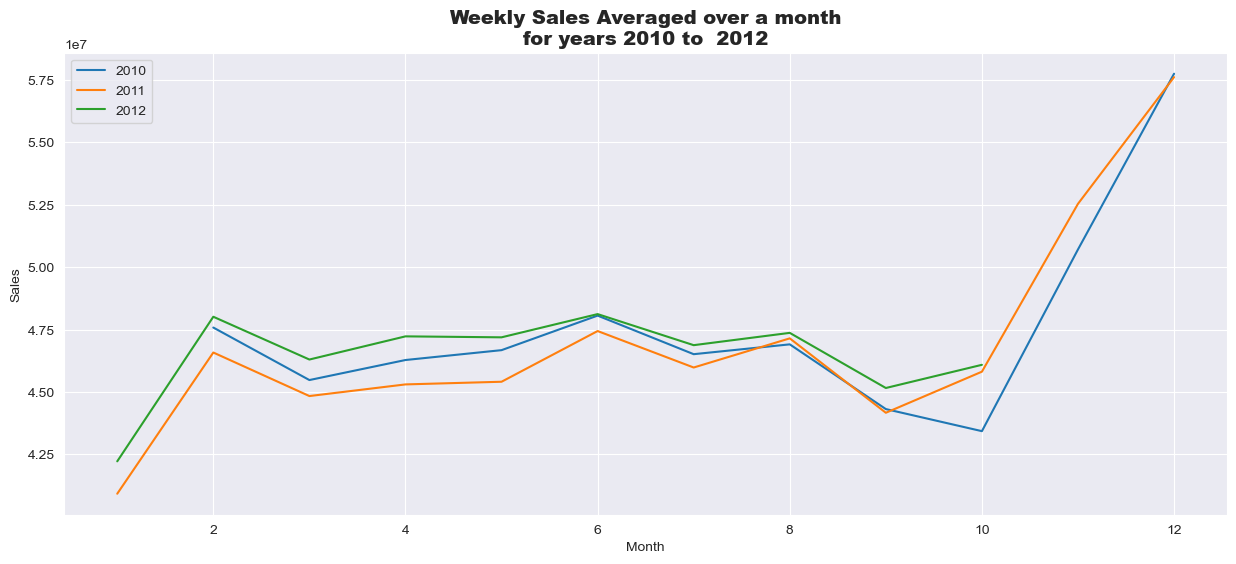

In [20]:
plt.subplots(figsize = (15,6))
plt.plot(month_pivot[2010], label = '2010')
plt.plot(month_pivot[2011], label = '2011')
plt.plot(month_pivot[2012], label = '2012')
plt.xlabel("Month")
plt.ylabel("Sales")
plt.title("Weekly Sales Averaged over a month" + "\n" + "for years 2010 to  2012", weight = 'black', fontsize = 14)
plt.legend()
plt.show()

- The sales peaks in 2nd, 6th and 8th months and after 10th month sales begins upward trend, also highest sales is recorded in december every year.
- As the major holidays falls at the end of the year, the upward trend is justified.
- One important observation to note that, each year sales follows the approximately same pattern, this observation will be helpful in modeling time series.

In [21]:
## weekly analysis
week_pivot = pd.pivot_table(total_df, values = 'Total_Sales',
              columns = 'Year',
              index = 'Week')
week_pivot.head()

Year,2010,2011,2012
Week,,,
1,NaN,42775787.77,44955421.95
2,NaN,40673678.04,42023078.48
3,NaN,40654648.03,42080996.56
4,NaN,39599852.99,39834974.67
5,49750740.5,46153111.12,46085608.09


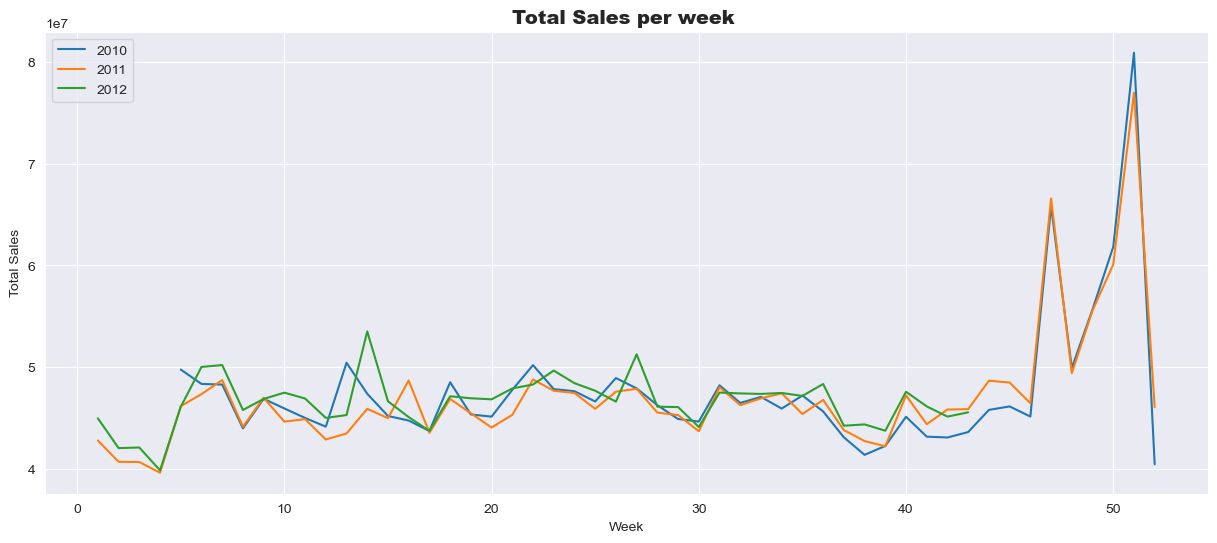

In [22]:
plt.subplots(figsize = (15,6))
plt.plot(total_df['Week'].loc[total_df['Year'] == 2010], total_df['Total_Sales'].loc[total_df['Year'] == 2010], label = '2010')
plt.plot(total_df['Week'].loc[total_df['Year'] == 2011], total_df['Total_Sales'].loc[total_df['Year'] == 2011], label = '2011')
plt.plot(total_df['Week'].loc[total_df['Year'] == 2012], total_df['Total_Sales'].loc[total_df['Year'] == 2012], label = '2012')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.title("Total Sales per week ", weight = 'black', fontsize = 14)
plt.legend()
plt.show()

- The weekly sales analysis again emphasize that the there is an increase in total sales during holiday weeks each year.
- There is evident sales hike in weeks 47 and 51 that corresponds to Thanksgiving and Christmas respectively.
- For the forecasting the 2012 sales this seasonality must be considered.
- Also, the graph implies that there is a patteren of immediate decline following the New Year.

### Part 2
- The sencond part of Exploratory Data Analysis looks into some of the advanced visualizations that answers the crititcal questions.
- As we have studied the overall sales summary on weekly sales, we will now study individual store data and factors affecting weekly sales.
- This section will focus on the following aspect of the Walmart Dataset.
    * Identifying how much sales increase during holidays.
    * If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?
    * If the weekly sales show a seasonal trend, when and what could be the reason?
    * Does temperature affect the weekly sales in any manner?
    * How is the Consumer Price index affecting the weekly sales of various stores?
    * Top performing stores according to the historical data.
    * The worst performing store, and how significant is the difference between the highest and lowest performing stores

**Numerical Variable Exploration**

ValueError: cannot reindex on an axis with duplicate labels

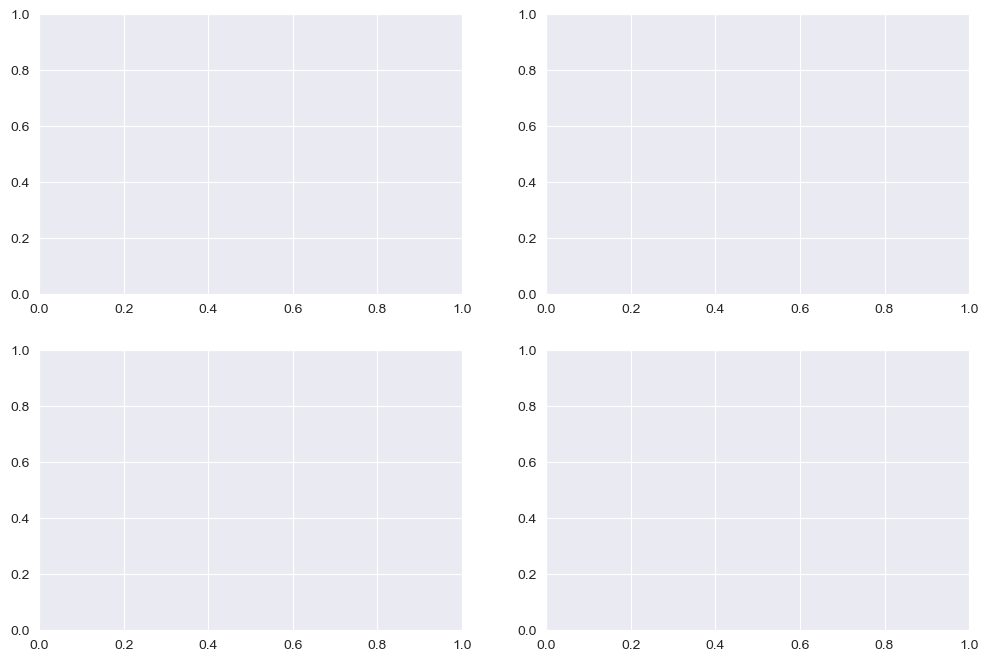

In [24]:
cols = ['Weekly_Sales','Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

plt.subplots(2,2, figsize = (12,8))

for i, col in enumerate(cols[:-1]):
    plt.subplot(2,2,i+1)
    sns.histplot(data = df, x = col, kde = True, palette= 'crest')

plt.show()

plt.subplots(figsize = (5.5,4))
sns.histplot(data = df, x = 'Unemployment', kde = True, palette= 'crest')
plt.show()

- The histogram for the individual numerical variables shows the distribution of that particular variable.
- Each histogram shows the range of values taken by the particular numerical variable.
- However apart from the range of values this plot don't suggest any relationship of the variable with the weekly sales. To infer the relationship we need to study impact of the variable on the weekly sales.
- We will explore impact of these variables in more depth in subsequent sections.

**Store Performance Evaluation**
- It is vital to study the Store performance based on weekly sales as it will lead us to highest and lowest performing stores that generate sales for walmart.
- I have created a barplot, where each bar describes the average weekly sales for the perticular store for the period of feb 2010 to oct 2012.
- These bars are ploted in descending fashion as it helps to indentify the highest and lowest performing stores.

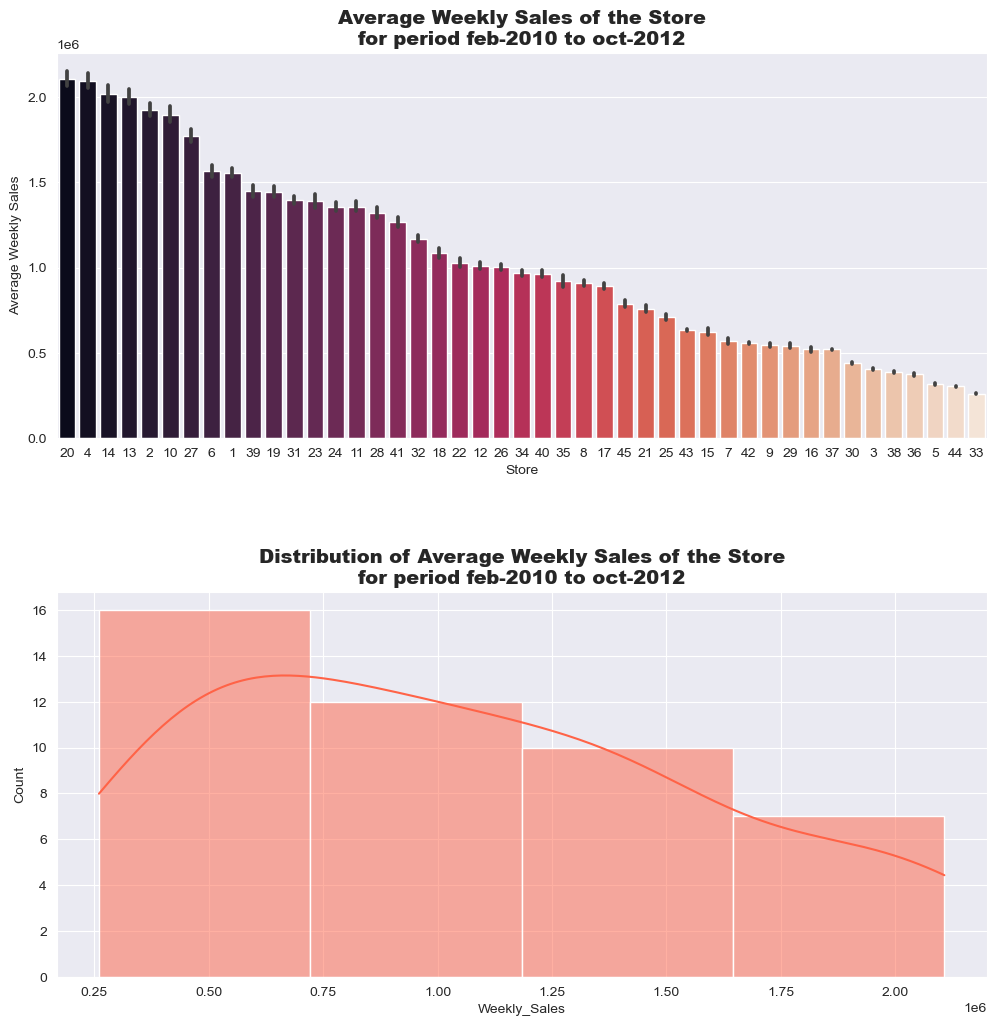

In [17]:
### Average weekly sales per store

plt.subplots(2, 1, figsize = (12,12))
plt.subplot(211)
order = df.groupby(by = 'Store').mean().sort_values(by = 'Weekly_Sales', ascending= False).index
sns.barplot(data = df, x = 'Store', y = 'Weekly_Sales', order = order, palette= 'rocket')
plt.ylabel("Average Weekly Sales")
plt.title("Average Weekly Sales of the Store" + '\n' + 'for period feb-2010 to oct-2012', weight = 'black', fontsize = 14)

plt.subplot(212)
sns.histplot(data = df.groupby(by = 'Store').mean(), bins = 4, x = 'Weekly_Sales', kde = True, color = 'tomato')
plt.title("Distribution of Average Weekly Sales of the Store" + '\n' + 'for period feb-2010 to oct-2012', weight = 'black', fontsize = 14)

plt.subplots_adjust(hspace = 0.4)
plt.show()

- Store 20 ,4 can be considered as a top performing store as the average weekly sales for these stores are over 2 million whereas stores 5,44,and 33 are the low performing stores.
- However, the performance can be affected by size and location of the store, since we don't have these variables we will stick with our observations.
- based on the Data stores 20,4,14,13,2 are the top 5 revenue generating stores for Walmart.

- From the plot "average weekly sales of the store for period feb-2010 to oct-2012" four types of stores are clearly visible, we will encode a category to each of the four store type to ease our further analysis.
    * Average weekly sales > 1.5 million =================>  'A'
    * 1 million < Average weekly sales <1.5 million ==========>  'B'
    * 500k < Average weekly sales < 1 million =============>  'C'
    * Average weekly sales < 500k =====================>  'D'
    

In [18]:
grp_df = df.groupby(by = 'Store').mean().sort_values(by = 'Weekly_Sales', ascending= False)
grp_df['type'] = 0
grp_df['type'].loc[grp_df['Weekly_Sales']> 1.5e6] = 'A'
grp_df['type'].loc[(grp_df['Weekly_Sales']> 1e6) & (grp_df['Weekly_Sales']< 1.5e6)] = 'B'
grp_df['type'].loc[(grp_df['Weekly_Sales']> 0.5e6) & (grp_df['Weekly_Sales']< 1e6)] = 'C'
grp_df['type'].loc[grp_df['Weekly_Sales']< 0.5e6] = 'D'
grp_df = grp_df.sort_index()

df['type'] = 0
for i in df['Store'].unique():
    df['type'].loc[df['Store'] == i] = grp_df['type'].loc[(grp_df.index == i)].values[0]
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year,type
Date,,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,A
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010,A
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010,A
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010,A
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010,A


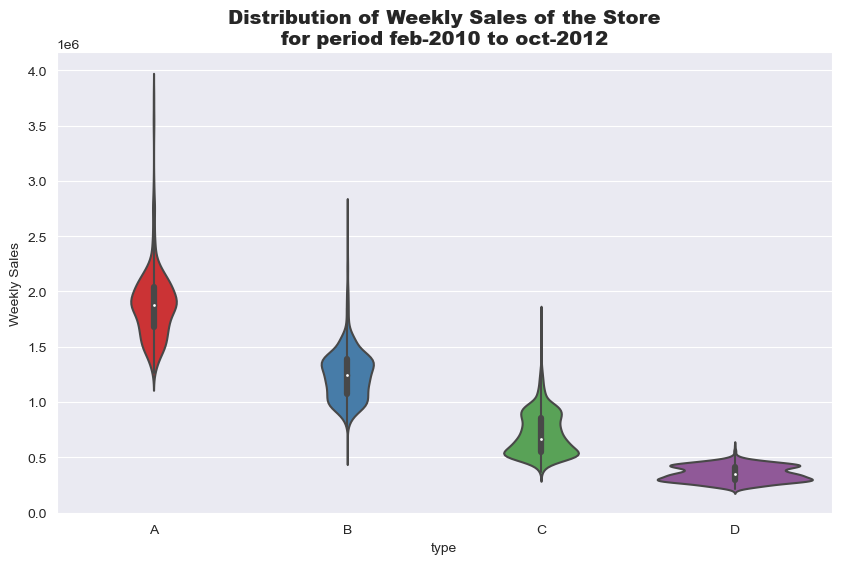

In [19]:
plt.subplots(figsize = (10,6))
sns.violinplot(data  = df, x = 'type', y = 'Weekly_Sales', order = ['A', 'B', 'C', 'D'], palette= 'Set1')
plt.ylabel("Weekly Sales")
plt.title("Distribution of Weekly Sales of the Store" + '\n' + 'for period feb-2010 to oct-2012', weight = 'black', fontsize = 14)
plt.show()

- The graph shows the distribution of weekly sales for each encoded store type

**Impact of Holidays on Sales:**
- The dataset includes the data about sales that occurs during the holiday periods of Thanksgiving, Christmas, etc.
- It is crucial to perform comparative analysis between the sales during the holidays and normal weeks to understand if the holiday seasongathers higher sales.
- For this analysis i have created 2 seperate bar plots.
    * 1st plot describes the average sales for Holidays and non-holidyas over the period of 2010-2012.
    * 2nd plot describes the count of holidays and non holidays over the period 2010-2012 present in the dataset.

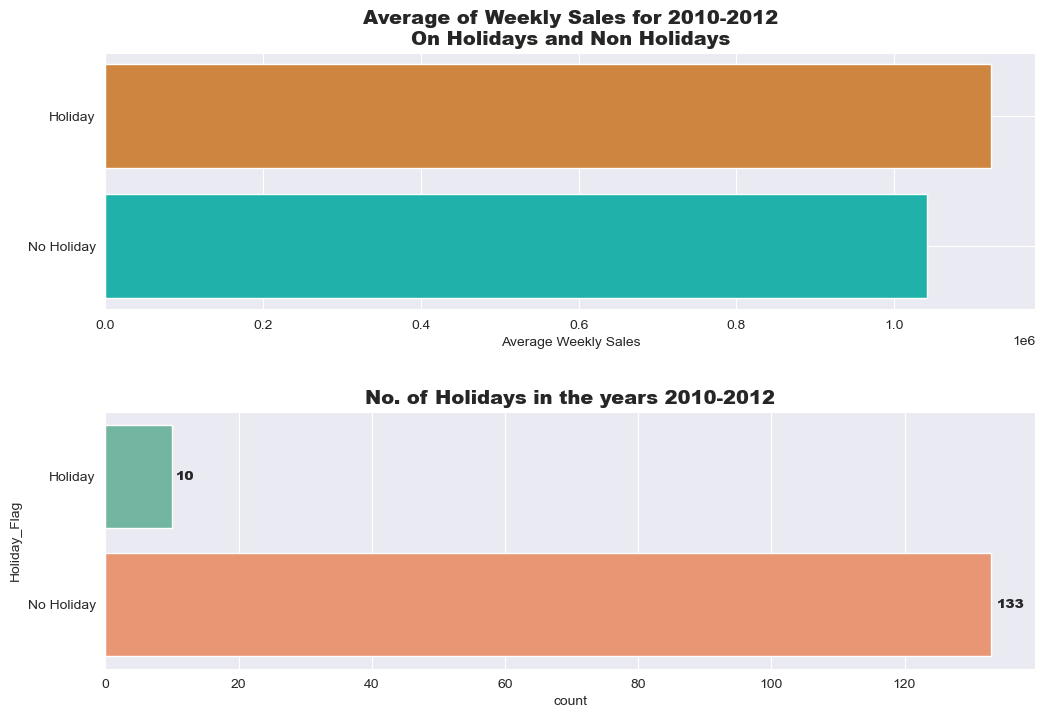

In [20]:
plt.subplots(2,1,figsize = (12,8))
plt.subplot(211)
plt.barh(y = df.groupby(by = 'Holiday_Flag').mean().index, 
        width = df.groupby(by = 'Holiday_Flag').mean()['Weekly_Sales'], 
        color =['lightseagreen', 'peru'])
plt.yticks(ticks = [0,1],
           labels = ["No Holiday","Holiday"])
plt.xlabel("Average Weekly Sales")
plt.title("Average of Weekly Sales for 2010-2012" + '\n' + 'On Holidays and Non Holidays', weight = 'black', fontsize = 14)

plt.subplot(212)
sns.countplot(data = df.loc[df['Store'] == 1], y = 'Holiday_Flag', palette= 'Set2', order=[1,0])
plt.title("No. of Holidays in the years 2010-2012", weight = 'black', fontsize = 14)
plt.yticks(ticks = [1,0],
           labels = ["No Holiday","Holiday"])
plt.text(x = 12, y = 0, s = '10', ha = 'center', va = 'center', weight= 'black')
plt.text(x = 136, y = 1, s = '133', ha = 'center', va = 'center', weight= 'black')
plt.subplots_adjust(hspace = 0.4)
plt.show()

- For each store in the period of 2010-2012, 10 Holidays are same.
- However, the suprising observation here is despite of only 10 holidays, the average sales for the period of 2010-2012 on holidays is approximately same or somewhat more.
- This implies that there is strong relationship between holiday and sales.

**Impact of Temperature on Sales:**

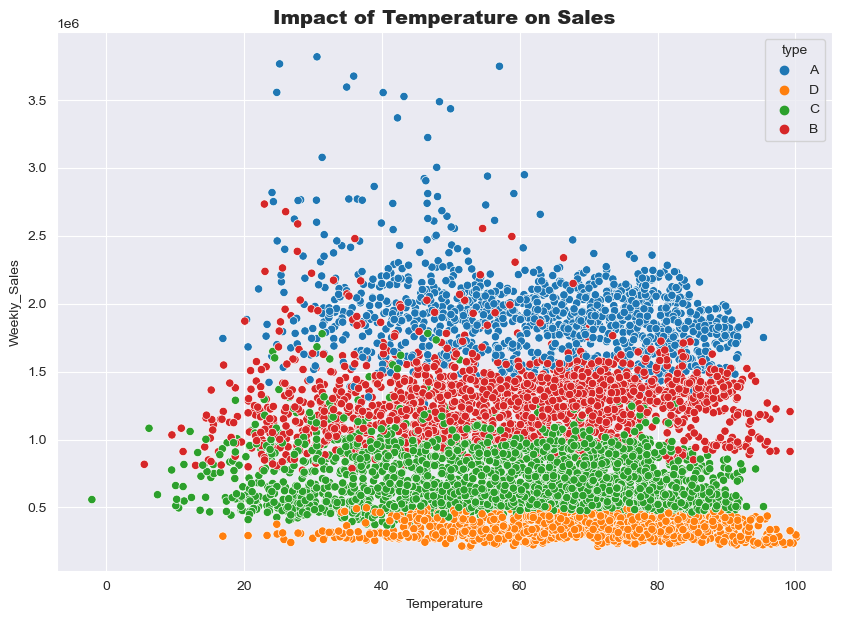

In [21]:
plt.subplots(figsize = (10,7))
sns.scatterplot(data = df, x = 'Temperature', y = 'Weekly_Sales', hue = 'type')
plt.title("Impact of Temperature on Sales", weight = 'black', fontsize = 14)
plt.show()

- The relationship between temprature and sales cannot be infered from the scatterplot.
- There is high sales for the temperature range of 25-50 F for A,B,C type of stores, apart from this all the store perform more or less in similar fashion in all the temperature range.

**Impact of Fuel Price on Sales:**
- It is a well known fact that as the fuel price increases, the production and transportation cost of the product aslo increases, and therefore the overall price of the product increases.
- This is certain across the industries.
- Thus the increase in fuel price has the negative effect on the sales.
- To analyze the impact of fuel price, I have created a scatter plot where on y axis Weekly sales is ploted and on X axis fuel price is ploted.

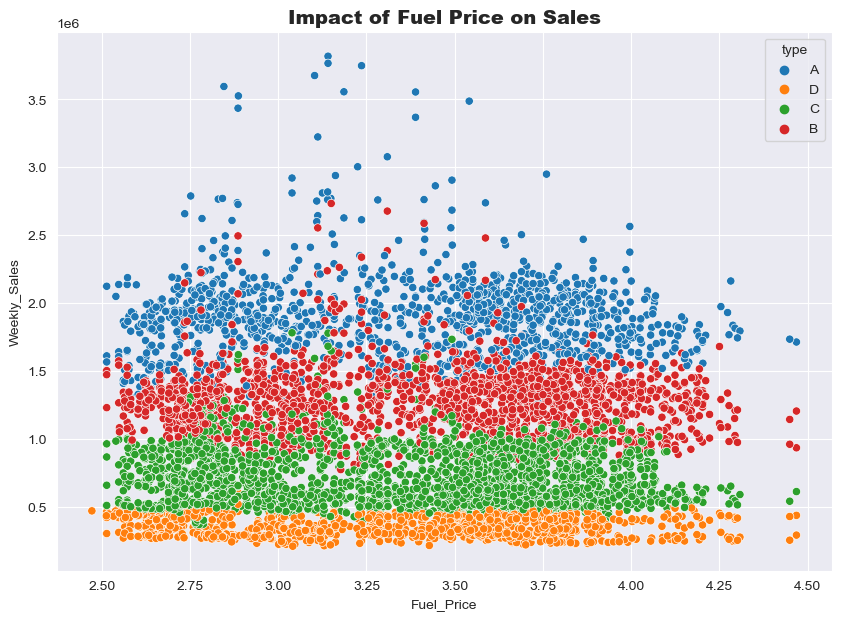

In [22]:
plt.subplots(figsize = (10,7))
sns.scatterplot(data = df, x = 'Fuel_Price', y = 'Weekly_Sales', hue = 'type')
plt.title("Impact of Fuel Price on Sales", weight = 'black', fontsize = 14)
plt.show()

- The decrease in sales is visible as the fule price goes above 4.25 compare to sales when the fuel price ranges between 2.75 to 3.75
- The highest sales for all type of the store are when the fuel price ranges between 2.75 to 3.75
- As there is no definite pattern to support the strong negative impact of the fuel price on the sales.
- The lack of definite pattern may be due to range of fuel price is too small to compare the sales.
- For larger period and larger fuel price range the negative impact could be definitive but for now we will consider little or no impact for walmart dataset.

**Impact of CPI on Sales:**

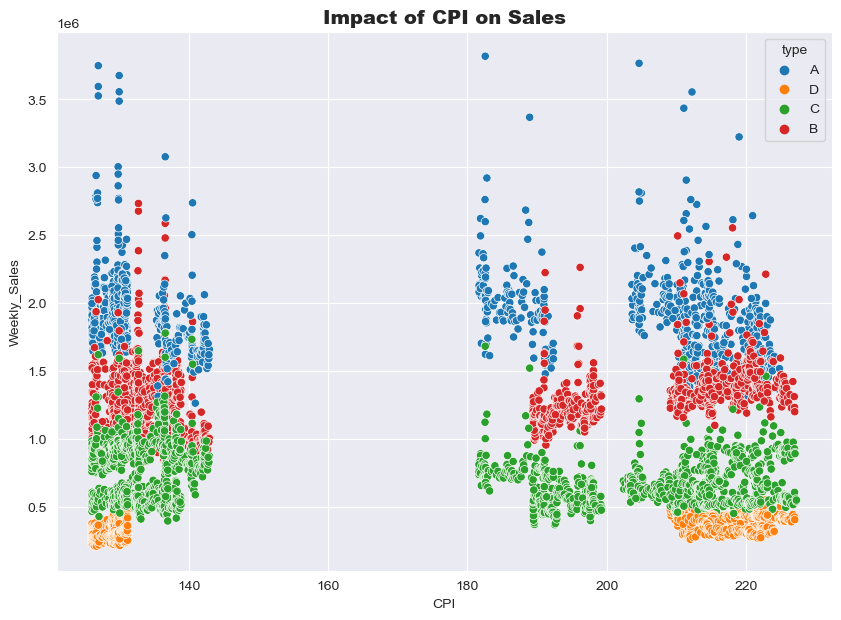

In [23]:
plt.subplots(figsize = (10,7))
sns.scatterplot(data = df, x = 'CPI', y = 'Weekly_Sales', hue = 'type')
plt.title("Impact of CPI on Sales", weight = 'black', fontsize = 14)
plt.show()

**Impact of Unemployment on Sales:**
- Similar to impact of petrol price, Unemployment too impact the sales negatively.
- It is easier to gather the insights about the impact of unemployment from the sctterplot between sales and unemployment.

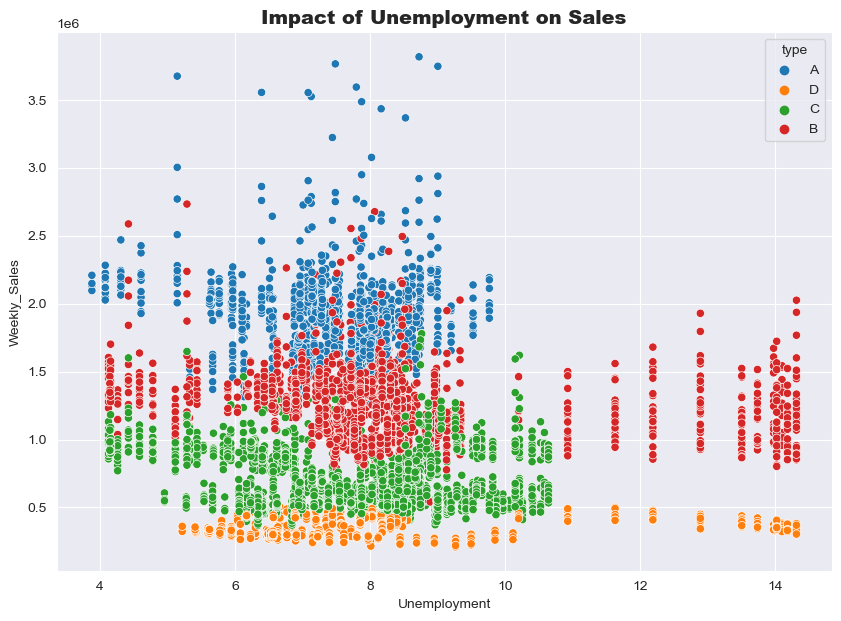

In [24]:
plt.subplots(figsize = (10,7))
sns.scatterplot(data = df, x = 'Unemployment', y = 'Weekly_Sales', hue = 'type')
plt.title("Impact of Unemployment on Sales", weight = 'black', fontsize = 14)
plt.show()

- For the given store type there is visible decline in sales as the unemployment increases.
- For the low performing stores the impact of unemployment is less.
- There seems to be significant drop in sales for the high performing stores.
- The highest recorded sales occur around the unemployment index of 8 to 10

In [25]:
df.corr()['Weekly_Sales']

Store          -0.335332
Weekly_Sales    1.000000
Holiday_Flag    0.036891
Temperature    -0.063810
Fuel_Price      0.009464
CPI            -0.072634
Unemployment   -0.106176
Week            0.074211
Month           0.076143
Year           -0.018378
Name: Weekly_Sales, dtype: float64

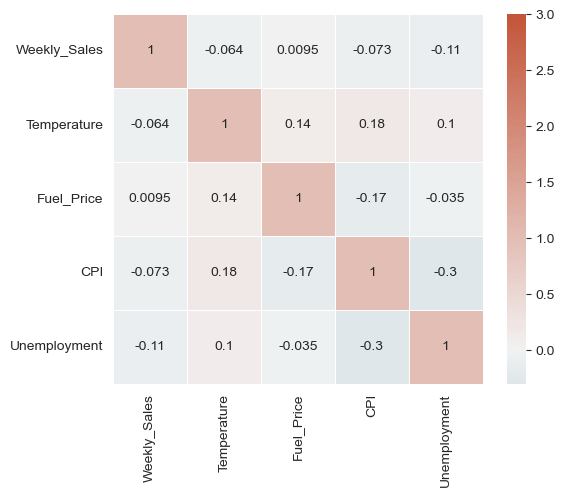

In [25]:
cmap = sns.diverging_palette(220,20, as_cmap = True)
sns.heatmap(df[cols].corr(), cmap = cmap, vmax = 3, center = 0, annot = True,
           square= True, linewidths = 0.5)
plt.show()

- There seems to be negative correlation between temperature, unemployment and CPI with the sales, however thecorrelation value is too small.
- negative sign implies the negative impact of the factor on the sales.

### Part 3
- In the first part of Exploratory Data Analysis we studied the total sales, and behaviour of sales for the month of the year and week of the year.
- In second part we explored the impact of the factors present in dataset on the weekly sales by performing visualisation.
- Also, in second part we tried to find the answer to the following questions through charts and graphs.
    * Identifying how much sales increase during holidays.
    * If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most?
    * If the weekly sales show a seasonal trend, when and what could be the reason?
    * Does temperature affect the weekly sales in any manner?
    * How is the Consumer Price index affecting the weekly sales of various stores?
    * Top performing stores according to the historical data.
    * The worst performing store, and how significant is the difference between the highest and lowest performing stores

- As we have explored enough, now we are ready to make assumptions about the dataset.
- This section will focus on the assumptions and hypothesis testing.
- We will find out the statistical significance of each factor  and will determine if the factor is usefull in predicting sales in this section.
   

In [26]:
from scipy import stats

In [27]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year,type
Date,,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,A
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010,A
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010,A
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010,A
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010,A


**Significance testing for Holiday:**
- From the EDA part 2, we can assume that the Holiday is correlated with sales value.
- To test our assumption we will perform oneway annova test on Holiday flag column.

- Hypothesis:
     * Ho : Variables are not correlated
             (The mean of all group are same)
     * H1 : Variable are correlated

In [28]:
holiday_sales = df.loc[df['Holiday_Flag'] == 1]['Weekly_Sales']
normal_sales = df.loc[df['Holiday_Flag'] == 0]['Weekly_Sales']

- we will test the assumption of the annova, i.e normality and homogenity of varianve 

In [29]:
from scipy import stats

## Normality test
#H0 : Normally Distributed
#H1 : Not normal

stat, pval = stats.shapiro(holiday_sales)
print("Stat:", stat)
print("pval:", pval)

Stat: 0.9449769258499146
pval: 7.148078136343106e-12


In [30]:
## Homogenity test
#H0 : All population variances are equal
#H1 : At least two of them differ

stat, pval = stats.levene(holiday_sales, normal_sales)
print("Stat:", stat)
print("pval:", pval)

Stat: 10.519203649624915
pval: 0.0011874337918717478


- pvalue < 0.05 implies that reject the null hypothesis with 95% significance.
- For both normality and homogenity of variance we got pval <0.05 therefore both the assumptions to conduct annova doesn't hold true for our dataset.
- As the assumptions of ANOVa doesn't satisfies we can opt for non-parametric test (Kruskal-Wallis test)

In [31]:
stat, pval = stats.kruskal(holiday_sales, normal_sales)
print("Stat:", stat)
print("pval:", pval)

Stat: 4.963273167380976
pval: 0.025891154949924652


- Since the pavl of Kruskal Wallis test is less than 0.05 we reject the null hypothesis, it implies that the holiday and sales are correlated.

**Significance testing for Temperature:**
- Since the temperature and sales are both numeric continuous type variable we will test significance of pearson r.
- Hypothesis:
     * Ho : Correlation is not statistically significant
             
     * H1 : Correlation is statistically significant

In [32]:
stat, pval = stats.pearsonr(x= df['Temperature'], y = df['Weekly_Sales'])
print("Stat:", stat)
print("pval:", pval)

Stat: -0.06381001317946965
pval: 3.007647625833215e-07


- p-value less than 0.05 implies that correlation is statistically significant

**Significance testing for Fuel Price:**
- Since the temperature and sales are both numeric continuous type variable we will test significance of pearson r.
- Hypothesis:
     * Ho : Correlation is not statistically significant
             
     * H1 : Correlation is statistically significant

In [33]:
stat, pval = stats.pearsonr(x= df['Fuel_Price'], y = df['Weekly_Sales'])
print("Stat:", stat)
print("pval:", pval)

Stat: 0.009463786314475139
pval: 0.44782874894857816


- p-value greater than 0.05 implies that correlation is statistically not significant

**Significance testing for CPI:**
- Since the temperature and sales are both numeric continuous type variable we will test significance of pearson r.
- Hypothesis:
     * Ho : Correlation is not statistically significant
             
     * H1 : Correlation is statistically significant

In [34]:
stat, pval = stats.pearsonr(x= df['CPI'], y = df['Weekly_Sales'])
print("Stat:", stat)
print("pval:", pval)

Stat: -0.07263416204017617
pval: 5.438292612176716e-09


- p-value less than 0.05 implies that correlation is statistically significant

**Significance testing for Unemployment:**
- Since the temperature and sales are both numeric continuous type variable we will test significance of pearson r.
- Hypothesis:
     * Ho : Correlation is not statistically significant
             
     * H1 : Correlation is statistically significant

In [35]:
stat, pval = stats.pearsonr(x= df['Unemployment'], y = df['Weekly_Sales'])
print("Stat:", stat)
print("pval:", pval)

Stat: -0.10617608965795447
pval: 1.3448365210232518e-17


- p-value less than 0.05 implies that correlation is statistically significant

**EDA Observations:**
- Only factor fuel price is statistically non significat. 
- All other factors : Store, Holiday_Flag, temperature, CPI, Unemployment are statistically significant with 0.05 level of significance.

## Model Building

- Based on the data analysis so far, I’ve decided that a time-series models are the most suitable for modeling and forecasting this dataset. Therefore, we’ll follow the general modeling procedure for a time series model
- The first concept to consider while building a model is that time series have an order, and we cancnot change that order when modeling. In time series forecasting, we express future values as a function of past values. Therefore it is trivial to maintain the order of the data so as to not violate relationship.
- With our historical data in hand we are ready build our forecasting model.
- Again, we will follow two aproaches for model building:
    * 1st aproach focuses on building a model that forecasts total sales of a walmart from all the stores.
    * 2nd aproach focuses on building a model that forecasts weekly sales of a individual store.


In [26]:
total_df.head()

,Holiday_Flag,Week,Month,Year,Total_Sales
Date,,,,,
2010-02-05,0,5,2,2010,49750740.50
2010-02-12,1,6,2,2010,48336677.63
2010-02-19,0,7,2,2010,48276993.78
2010-02-26,0,8,2,2010,43968571.13
2010-03-05,0,9,3,2010,46871470.30


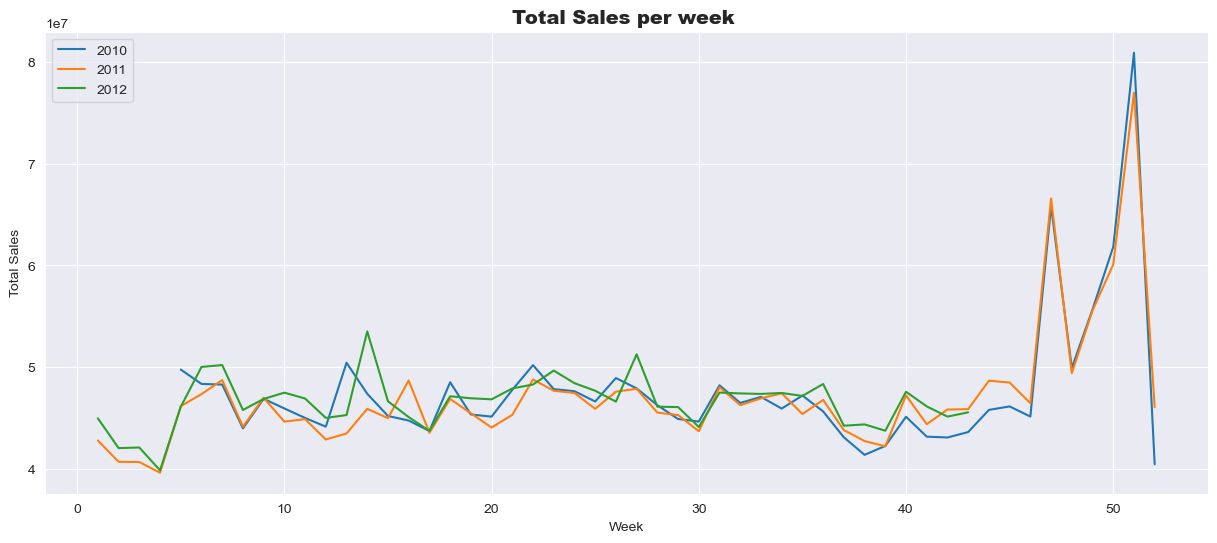

In [27]:
plt.subplots(figsize = (15,6))
plt.plot(total_df['Week'].loc[total_df['Year'] == 2010], total_df['Total_Sales'].loc[total_df['Year'] == 2010], label = '2010')
plt.plot(total_df['Week'].loc[total_df['Year'] == 2011], total_df['Total_Sales'].loc[total_df['Year'] == 2011], label = '2011')
plt.plot(total_df['Week'].loc[total_df['Year'] == 2012], total_df['Total_Sales'].loc[total_df['Year'] == 2012], label = '2012')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.title("Total Sales per week ", weight = 'black', fontsize = 14)
plt.legend()
plt.show()

- As discussed in the EDA section we can see that,
    - The weekly sales analysis again emphasize that the there is an increase in sales during holiday weeks each year.
    - There is evident sales hike in weeks 47 and 51 that corresponds to Thanksgiving and Christmas respectively.
    - For the forecasting the 2012 sales this seasonality must be considered.
    - Also, the graph implies that there is a patteren of immediate decline following the New Year.

**Data Decomposition**

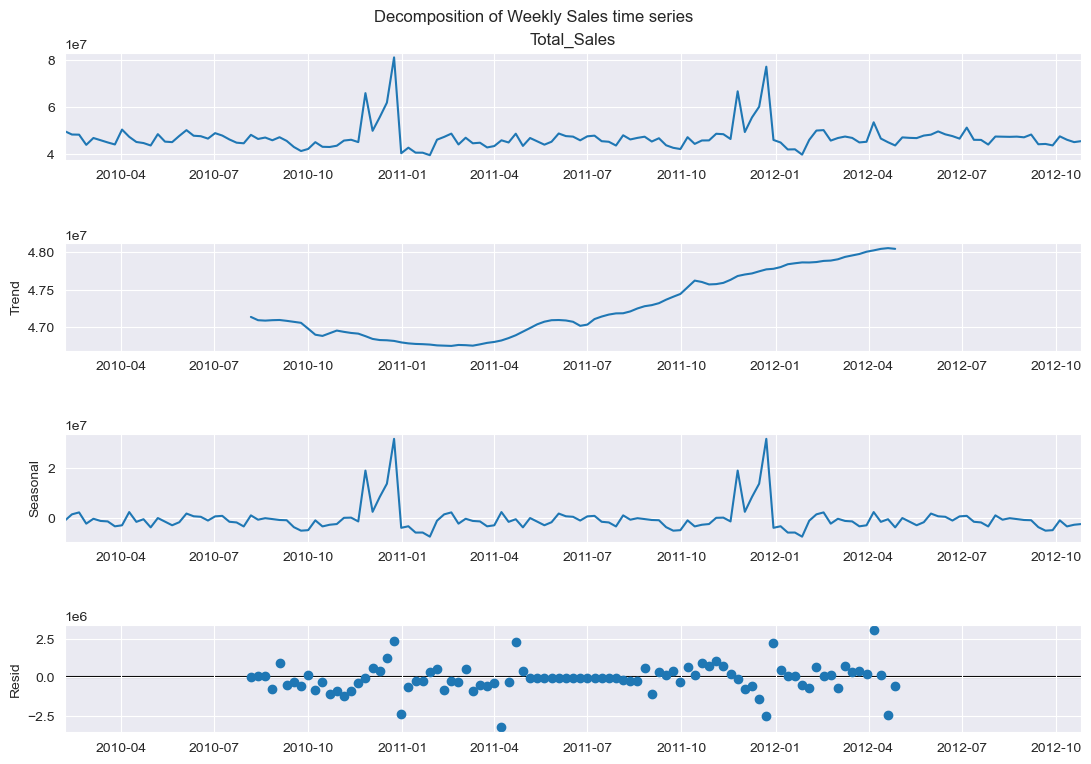

In [28]:
decompose = seasonal_decompose(total_df['Total_Sales'], model = 'additive', period = 52)
fig = decompose.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of Weekly Sales time series')
plt.show()

- Decomposition method is applied to identify and seperate out the three components i.e. trend, seasonality and irregular components from the given series to observe their independent properties.
- Fig indicates that trend is increasing linearly. there is significant seasonality present.


**Train Test Spliting**
- Before model building, I split the dataset into train and test sets. The train set will consist of data from '2010-02-05' to the '2012-08-24', and test sell will consist of data points for 9 weeks (i.e. 9 data points).
- The train set will be the only dataset we use to develop a model. Whereaswe we will compare our forecast with test set to evaluate model performance.
- I set the horizon of the model to 9 weeks. Since our data set contains weekly sales and data is avalialbe till 43rd week of the year 2012. We will forecast the data till 52nd week.

In [136]:
train = total_df.iloc[: -12, -1]
test = total_df.iloc[-12:, -1]

train = pd.DataFrame(data = train)
test = pd.DataFrame(data = test)

**Naive Model Building**
- As I have set the horizon and split our dataset now the next step is to build a model. I have builded a naive model first and then improved a forecasting by building more complex models.
- Naive model is necessary to set a baseline for the forecasting problem. Building a naive model helps us measuring performance of complex models.

In [137]:
from sklearn.metrics import mean_absolute_percentage_error
error_df = pd.DataFrame(index= ['MAPE','RMSE'])

def print_err(col, Name):
    
    MAPE = mean_absolute_percentage_error(test['Total_Sales'], test[col])
    RMSE = np.sqrt(mean_squared_error(test['Total_Sales'], test[col]))
    
    error_df.loc['MAPE', col] = MAPE
    error_df.loc['RMSE', col] = RMSE

    print(f"""-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for {Name} forecast is : {MAPE:.4f}
    Root Mean Squared Error for {Name} forecast is : {RMSE:.4f}
    -------------------------------------------------------------------------------""")

In [138]:
def plt_forecast(col):
    fig, ax = plt.subplots(figsize = (8,8))

    ax.plot(train.index, train['Total_Sales'], 'b-', label = 'Train')
    ax.plot(test.index, test['Total_Sales'], 'g-', label = 'Test')
    ax.plot(test.index, test[col], 'r--', label = 'Predicted')
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend()
    fig.autofmt_xdate()

**Forecast-1 : Historical Mean**

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Historical mean forecast is : 0.0301
    Root Mean Squared Error for Historical mean forecast is : 1794183.4473
    -------------------------------------------------------------------------------


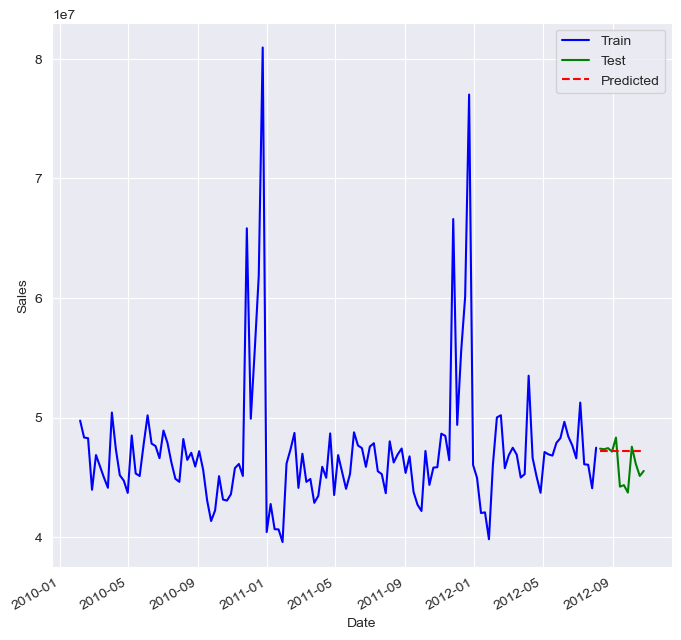

In [139]:
## implementing historical mean forecast.
historical_mean = np.mean(train)
test.loc[:, 'pred_mean'] = historical_mean.values[0]  ## seting a historical mean to pred_mean column
print_err('pred_mean', 'Historical mean')
plt_forecast('pred_mean')

- The MAPE (mean absolue percentage error) implies that our naive forcast deviates by 0.03% on average from the observed total sales.
- Just by evaluating MAPE suggests that we have found the best model, however the plot of train test and predicted sales, and the RMSE (root mean sqaured error) suggest there is lot more variation in the model that is unexplained by the naive historical mean method.
- The standard deviation of the historical mean model is 2071366.6700, which is very large and for further models we will try to minimize this RMSE value.

**Forecast-2 : Last Known Value**

In [140]:
## Forecasting last known value

last = train['Total_Sales'].iloc[-1]
test.loc[:, 'last'] = last
test.head()


,Total_Sales,pred_mean,last
Date,,,
2012-08-10,47403451.04,4.719730e+07,47485899.56
2012-08-17,47354452.05,4.719730e+07,47485899.56
2012-08-24,47447323.60,4.719730e+07,47485899.56
2012-08-31,47159639.43,4.719730e+07,47485899.56
2012-09-07,48330059.31,4.719730e+07,47485899.56


In [141]:
print_err('last', 'Last known value')

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Last known value forecast is : 0.0322
    Root Mean Squared Error for Last known value forecast is : 1969608.5788
    -------------------------------------------------------------------------------


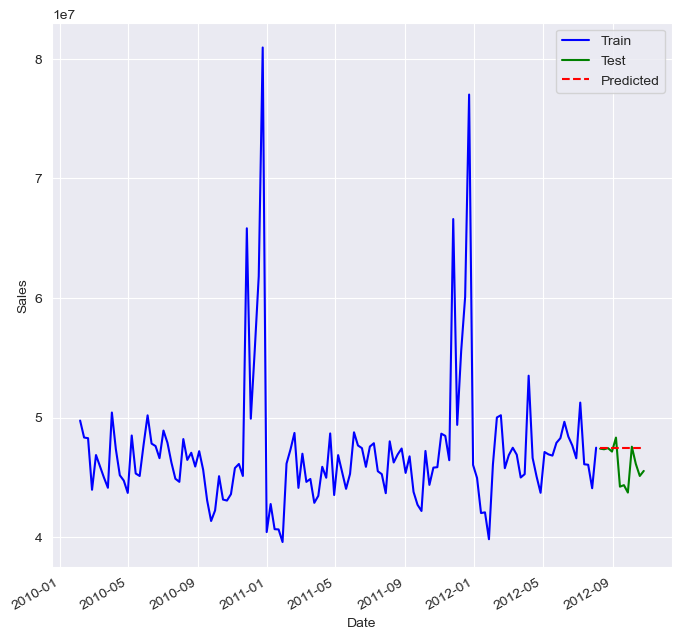

In [142]:
plt_forecast('last')

- Forecasting a value as alast known value yeilds more or less same MAPE with our baseline historical mean model but the variance increases.
- The RMSE increases from 2071366.6700 to 2245166.0197 compare to historical mean model, our objective was to minimize the RMSE value therefore we will build another model.
- Both the models historical mean and last known value considered the trend component of the data however fails to consider the seasonal (cyclic) variations in the data. Therefore we've got large variations.

**Forecast-3 : Exponential Smoothing**

##### Simple Exponential Smoothing Method (SES):
- SES or one-parameter exponential smooting is defined as followint equation:
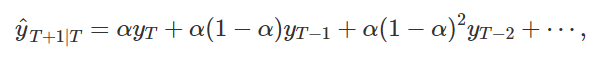
- This is weighted average of  of all of the observations in the series. The rate at which the weights decrease is controlled by the parameter alpha.
- Pythons statsmodel finds the optimal alpha for us, I have used statsmodel to compute alpha and predict future values

In [143]:
ES_model = ExponentialSmoothing(train).fit(optimized= True)
ES_model.params_formatted

,name,param,optimized
smoothing_level,alpha,3.618605e-01,True
initial_level,l.0,4.785282e+07,True


In [144]:
ES_pred = ES_model.forecast(steps = len(test))
test.loc[:, 'ES_pred'] = ES_pred
test.head()

,Total_Sales,pred_mean,last,ES_pred
Date,,,,
2012-08-10,47403451.04,4.719730e+07,47485899.56,4.659577e+07
2012-08-17,47354452.05,4.719730e+07,47485899.56,4.659577e+07
2012-08-24,47447323.60,4.719730e+07,47485899.56,4.659577e+07
2012-08-31,47159639.43,4.719730e+07,47485899.56,4.659577e+07
2012-09-07,48330059.31,4.719730e+07,47485899.56,4.659577e+07


In [145]:
print_err('ES_pred', 'Exponential Smoothing')

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Exponential Smoothing forecast is : 0.0296
    Root Mean Squared Error for Exponential Smoothing forecast is : 1542179.1656
    -------------------------------------------------------------------------------


In [146]:
error_df

,pred_mean,last,ES_pred
MAPE,3.006944e-02,3.216044e-02,2.955479e-02
RMSE,1.794183e+06,1.969609e+06,1.542179e+06


In [147]:
def get_diff(col):
    RMSE_diff = (error_df.loc['RMSE', 'pred_mean'] - error_df.loc['RMSE', col])
    MAPE_diff = (error_df.loc['MAPE', 'pred_mean'] - error_df.loc['MAPE', col])
    diff = {'MAPE_Diff': np.round(MAPE_diff,4), 
            'RMSE_diff': np.round(RMSE_diff, 4)}
    return diff

In [148]:
get_diff('ES_pred')

{'MAPE_Diff': 0.0005, 'RMSE_diff': 252004.2816}

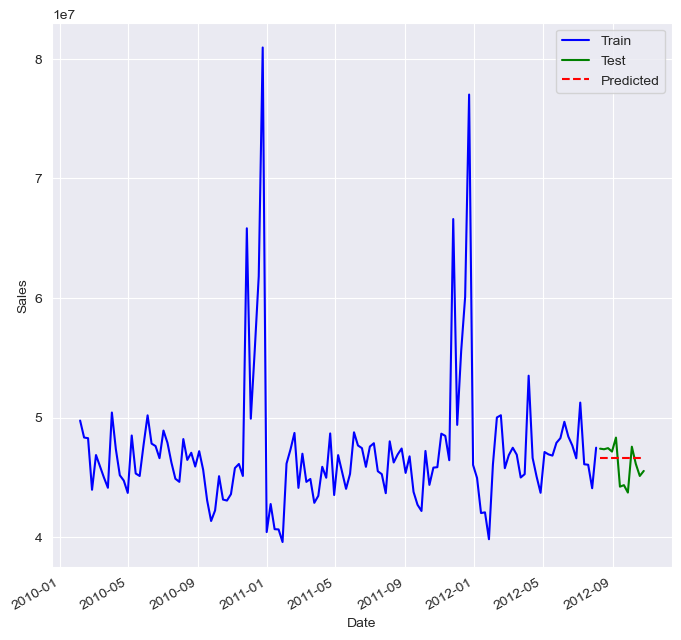

In [149]:
plt_forecast("ES_pred")

- Exponential smoothing model lowered RMSE (standard deviation) of forcast by 2546.96 while the MAPE is still the same.
- Exponential smoothing model neither considers trend nor the seasonality. Therefore there is still large RMSE.

##### Double Exponential Smoothing Method (Holt's Method):

In [150]:
DES_model = ExponentialSmoothing(train, trend = 'additive').fit(optimized= True)
DES_pred = DES_model.forecast(steps = len(test))
test.loc[:, 'DES_pred'] = DES_pred
test.head()

,Total_Sales,pred_mean,last,ES_pred,DES_pred
Date,,,,,
2012-08-10,47403451.04,4.719730e+07,47485899.56,4.659577e+07,4.616760e+07
2012-08-17,47354452.05,4.719730e+07,47485899.56,4.659577e+07,4.601516e+07
2012-08-24,47447323.60,4.719730e+07,47485899.56,4.659577e+07,4.586272e+07
2012-08-31,47159639.43,4.719730e+07,47485899.56,4.659577e+07,4.571027e+07
2012-09-07,48330059.31,4.719730e+07,47485899.56,4.659577e+07,4.555783e+07


In [151]:
print_err('DES_pred', 'Double Exponential Smoothing')

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Double Exponential Smoothing forecast is : 0.0310
    Root Mean Squared Error for Double Exponential Smoothing forecast is : 1571982.5816
    -------------------------------------------------------------------------------


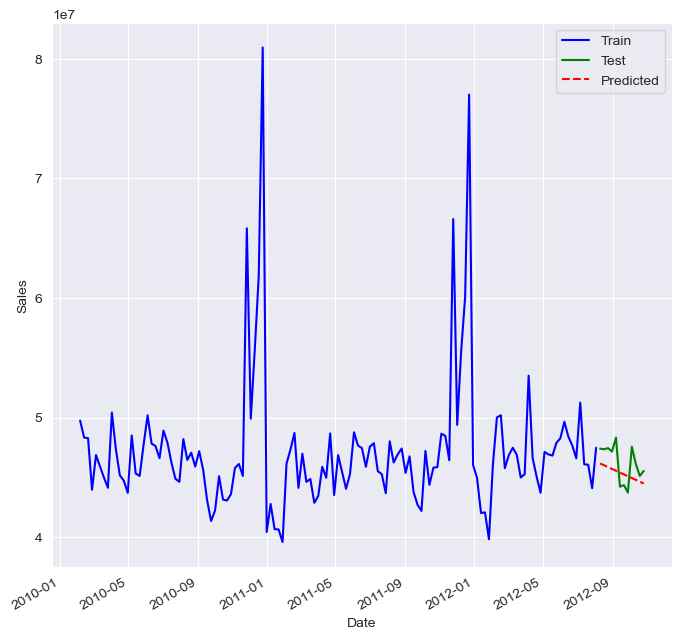

In [152]:
plt_forecast('DES_pred')

In [153]:
get_diff('DES_pred')

{'MAPE_Diff': -0.0009, 'RMSE_diff': 222200.8657}

- Double Exponential smoothing model lowered RMSE (standard deviation) of forcast by 545513.6153 which is 25% of our naive model while the MAPE is still the same.
- Double Exponential smoothing model do considers trend but not the seasonality as we can sea in figure.

##### Tripple Exponential Smoothing Method (Holt-Winter's Method):

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Triple Exponential Smoothing forecast is : 0.0156
    Root Mean Squared Error for Triple Exponential Smoothing forecast is : 899961.8380
    -------------------------------------------------------------------------------


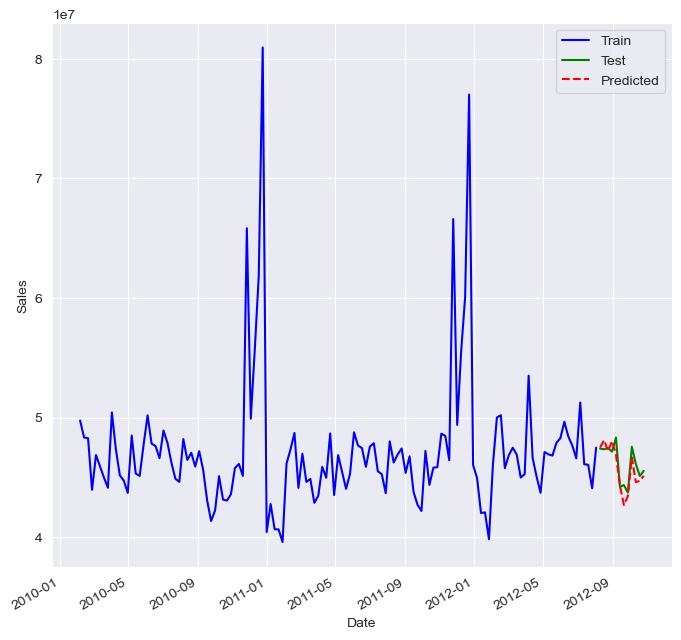

In [154]:
from statsmodels.tsa.api import ExponentialSmoothing
TES_model = ExponentialSmoothing(train, trend = 'additive',seasonal= 'additive').fit(optimized= True)
TES_pred = TES_model.forecast(steps = len(test))
test.loc[:, 'TES_pred'] = TES_pred
print_err('TES_pred', 'Triple Exponential Smoothing')
plt_forecast('TES_pred')

In [155]:
get_diff('TES_pred')

{'MAPE_Diff': 0.0145, 'RMSE_diff': 894221.6093}

- Triple Exponential smoothing model lowered RMSE (standard deviation) of forcast by 1037073.432 which is 50% of our naive model while the MAPE is still the same.
- Triple Exponential smoothing model do considers both trend and the seasonality.
- The figure shows the model is well fitted on the testing data. However we have explored only decomposition methods for forecasting.
- The regression methods of forecasting are still needs to be explored. Regression methods are based on the regression on the past observations. Whereas the decomposition methods are based on the extraction of individual components of time series.

**Forecast-4 : Regression Methods**

##### Auto Regressive Moving Average (ARMA):
- ARIMA models are applied when the current value is assumed to be correlated to past values (AR process) and past prediction errors (MA process)
- ARIMA is a combination of AR (auto regressive) and MA (moving average process), it states that the present value is linearly dependent on its own previous values as well as on the mean, current error terms and past error terms.
- It is denoted as ARMA (p, q) where, 
    * p - is the order of auto regressive process.
    * q - is the order of moving average process.
- The ARMA process can be identified by using ACF and PACF plots.
    - ACF measures the strength of dependency of current observations on past observations.
    - PACF provides the correlation value between current and k-lagged series by removing the influence of all other observations that exist in between.
- One special care has to be taken before identifying the order of process and modeling and prection, that the ARMA assumes stationarity. That is the mean and the variance of a process is constant over a period of time, and the correlation between the two time periods depends only on the distance or lag between the two periods.
- Therefore, Augmented Dickey-Fuller test was conducted first to check the stationarity.
    * H0: Time Series is non-stationary
    * H1: Time Series is stationary

In [156]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(train)

print(f'ADF Statistic {ADF_result[0]}')
print(f'p-value {ADF_result[1]}')

ADF Statistic -5.667865856980574
p-value 9.063916855404198e-07


In [157]:
ADF_result = adfuller(decompose.seasonal)

print(f'ADF Statistic {ADF_result[0]}')
print(f'p-value {ADF_result[1]}')

ADF Statistic -5.913398012001533
p-value 2.6066955770100113e-07


- p-value less than 0.05 implies that rejct the null hypothesis and Time series is stationary with 0.05 level of significance.

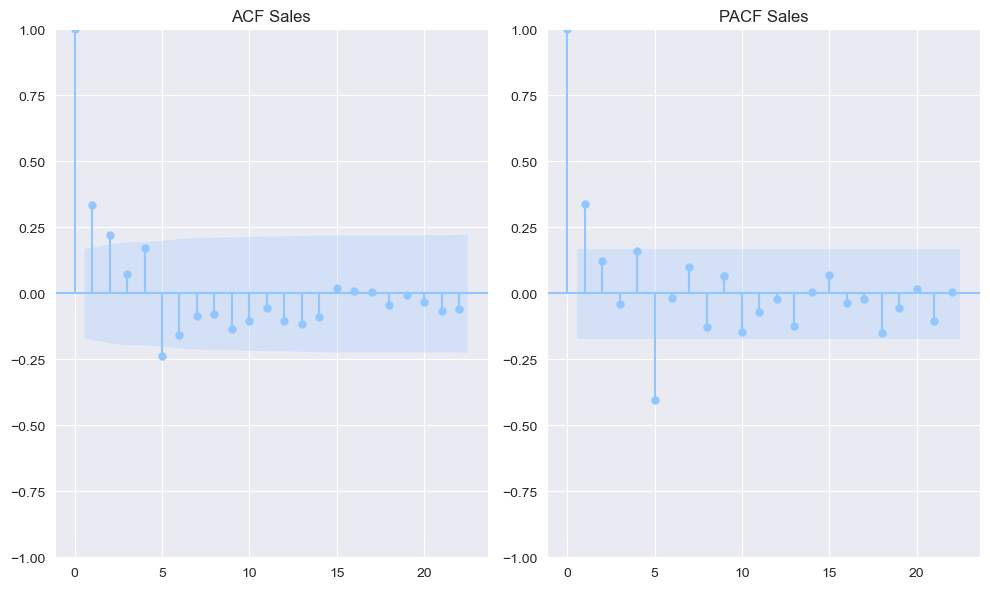

In [158]:
## ACF and PACF plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(1,2, figsize = (10,6))

acf = plot_acf(train, title = 'ACF Sales', ax = axes[0])
pacf = plot_pacf(train, title = 'PACF Sales', ax = axes[1])
plt.tight_layout()

- The ACF plot shows the sinusoidal pattern which isindication of a Autoregressive process.
- The light blue band in the plot shows the significance level. The values inside the band is sgnificantly zero.
- From the ACF plot it can be infered that last signifcant coefficient is at lag 2 which suggests Moving average process of order 2 (i.e q = 2)
- From the PACF plot it can be infered that last signifcant coefficient is at lag 1 which suggests Autoregressive process of order 1 (i.e p = 1)
- To infer order of MA(q) and AR(p) process from ACF and PACF plots there should be clear cuttoff between significant and non-significant coefficient in both ACF and PACF plots. Then the cuoff lag dictates the order of respective process.
- In our plot coefficient at lag 5 again become significant after cuttoff, we assumed this due to by chance and with this assumption order of ARMA process is (1,2), i.e ARMA(1,2)
- However this assumption of by chance is not good in modeling as the order of the process is key in forcasting. The order will determine how many parameters must be included in model.
- Therefore Akaike Information Criterion (AIC) is used to find the optimal order of the process. AIC estimates the quality of a model relative to other models. Lower the value of the AIC, better ther model.

In [75]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

ps = range(0,8,1) # create a list of possible values for 'p' starting from 0
qs = range(0,8,1) # create a list of possible values for 'q' starting from 0

order_ls = list(product(ps, qs)) # generate a list of all unique combinations of (p,q)

results = []
for order in order_ls:
    model = SARIMAX(train,
                   order = (order[0], 0, order[1]),
                   simple_differencing = False).fit()
    aic = model.aic
    results.append([order, aic])
    
results_df = pd.DataFrame(results, columns= ['(p,q)', 'AIC']).sort_values(by = 'AIC').reset_index()
results_df

,index,"(p,q)",AIC
0,13,"(1, 5)",4427.513792
1,14,"(1, 6)",4428.764917
2,22,"(2, 6)",4431.575280
3,49,"(6, 1)",4432.136677
4,57,"(7, 1)",4432.890100
...,...,...,...
59,3,"(0, 3)",4894.402583
60,7,"(0, 7)",4895.539231
61,2,"(0, 2)",4896.779197
62,1,"(0, 1)",4921.363873


- Results shows that the order of ARMA process infered from the ACF and PACF plot is not valid and the correct ARMA process is  ARMA(1,5) with lowest AIC

In [159]:
model = SARIMAX(train, 
                order = (1,0,5), 
                simple_differencing= False).fit()


- As,we have found out the optimal order of the ARMA(p,q) process using AIC and fitted the model with optimal parameters. Now we must guage the quality of the fitted model.
- The quality can be measured by the performing residual analysis. The quality of model is considerably best when the residuals of the model (difference bwt predicted and acual values) posses properties of white nose. These properties are:
    * residuals are normaly distributed
    * resicuals are uncorrelated
- If both the properties satisfies then our model can be used for the forecasting otherwise we should change order of the model.

**Residual Analysis**

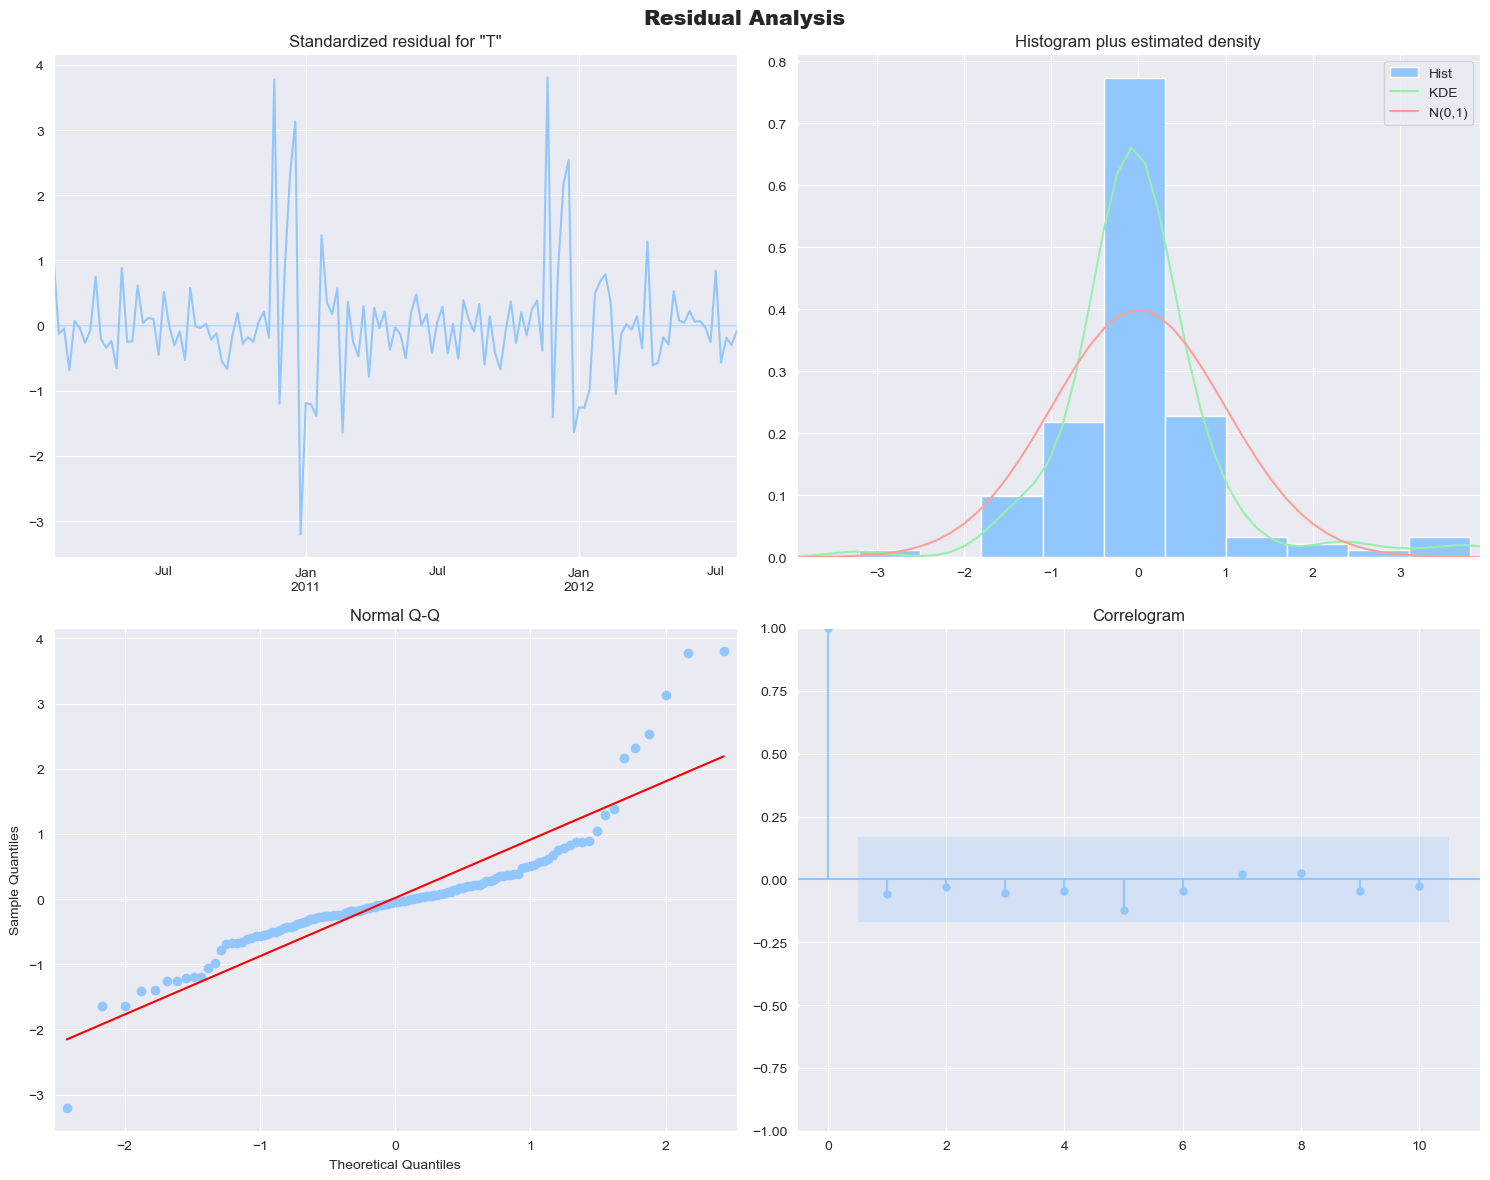

In [160]:
plt.style.use('seaborn-pastel')
model.plot_diagnostics(figsize=(15, 12))
plt.suptitle('Residual Analysis', weight = 'black', fontsize = 15)
plt.tight_layout()
plt.show()

In [161]:
## quantitative analysis for residual correlation

from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(model.resid, np.arange(1,11,1))


,lb_stat,lb_pvalue
1,0.213457,0.644072
2,0.266657,0.875177
3,0.844285,0.838848
4,0.918637,0.921872
5,1.594495,0.901914
6,1.805010,0.936730
7,1.809827,0.969613
8,2.148016,0.976135
9,2.326066,0.985201
10,2.468848,0.991322


- The dignostic plots shows the qualitative analysis of residuals.
- The top-left plot shows the residuals across the entire dataset. There is no trend the plot and mean is also stable over time it implies that the residuals are just white noise (a random stationary process)
- The top-right plot shows a histogram of the residuals. The shape of the histogram is similar to the shape of normal distribution this is indicates that the residuals are close to white noise.
- Bootom-left plot is a Q-Q plot, it plots the distibution of residuals against a theoretical normal distribution. The distribution of the residuals seems similar to a normal distribution. It suggests that the model is a good fit.
- Bottom-right plot shows the autocorrelation function of our residuals. The plot shows that there is only a significant peak at lag 0, which supports the conclusion that the residuals are not correlated and therefore they are similar to white noise.
- Ljung-Box test, a statistical test applied to a residuals to measure whether the residuals are uncorrelated or not is then applied to residuals up to lag 10.
- The result of the test shows that the p-value at each lag is greater than 0.05 therefore we fail to reject null hypothesis meaning residuals are uncorrelated and independantly distributed.
- Therefore in conclusion, residuals are similar to white noise process. And it is measure of goodness of fit of our model.

**Forecasting:**

In [162]:
pred_f = model.get_forecast(steps = len(test))
ARMA_pred = pred_f.summary_frame(alpha = 0.05)['mean']
test.loc[:, 'ARMA_pred'] = ARMA_pred
test.head()

,Total_Sales,pred_mean,last,ES_pred,DES_pred,TES_pred,ARMA_pred
Date,,,,,,,
2012-08-10,47403451.04,4.719730e+07,47485899.56,4.659577e+07,4.616760e+07,4.749757e+07,4.483163e+07
2012-08-17,47354452.05,4.719730e+07,47485899.56,4.659577e+07,4.601516e+07,4.812249e+07,4.634928e+07
2012-08-24,47447323.60,4.719730e+07,47485899.56,4.659577e+07,4.586272e+07,4.720675e+07,4.635419e+07
2012-08-31,47159639.43,4.719730e+07,47485899.56,4.659577e+07,4.571027e+07,4.802999e+07,4.698046e+07
2012-09-07,48330059.31,4.719730e+07,47485899.56,4.659577e+07,4.555783e+07,4.691396e+07,4.719504e+07


In [163]:
print_err('ARMA_pred', 'ARMA')

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for ARMA forecast is : 0.0374
    Root Mean Squared Error for ARMA forecast is : 1985110.1912
    -------------------------------------------------------------------------------


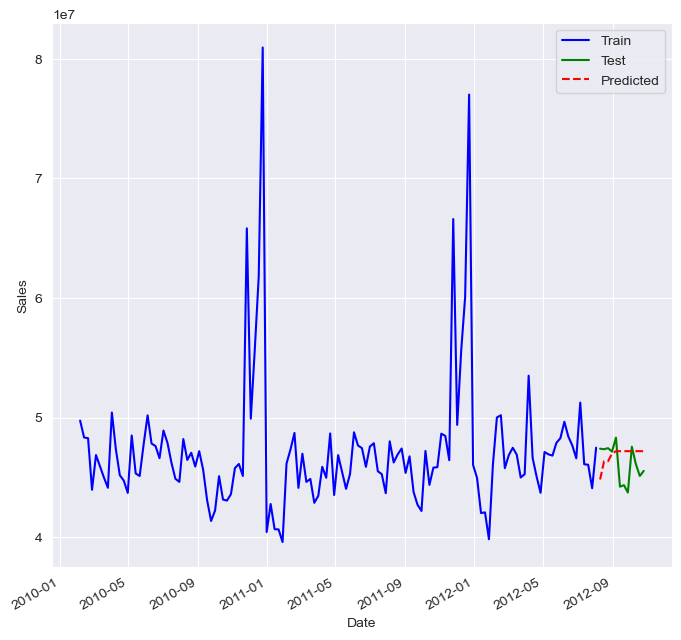

In [164]:
plt_forecast('ARMA_pred')

In [165]:
get_diff('ARMA_pred')

{'MAPE_Diff': -0.0074, 'RMSE_diff': -190926.7439}

##### Seasonal Auto Regressive Integrated Moving Average (SARIMA):

- Seasonal ARIMA models are more complex models with seasonal adjustments.

In [75]:
ps = range(0,5) # try the values [] for p
qs = range(0,4) # try the values [] for p
Ps = range(0,4) # try the values [] for P
Qs = range(0,4) # try the values [] for Q

d = 0
D = 0
s = 52 # weekly data implies 52 as a frequency

order_ls = list(product(ps, qs, Ps, Qs)) ##Generate the unique combinations of orders.

results = []
for order in order_ls:
    model = SARIMAX(train,
                   order = (order[0], d, order[1]),
                    seasonal_order= (order[2], D, order[3], s),
                   simple_differencing = False).fit()
    aic = model.aic
    #print([order, aic])
    results.append([order, aic])
    
    
results_df = pd.DataFrame(results, columns= ['(p,q, P, Q)', 'AIC']).sort_values(by = 'AIC').reset_index()
results_df

,index,"(p,q)",AIC
0,178,"(2, 3, 0, 2)",2592.512511
1,24,"(0, 1, 2, 0)",2592.616507
2,18,"(0, 1, 0, 2)",2592.655781
3,184,"(2, 3, 2, 0)",2592.768981
4,21,"(0, 1, 1, 1)",2593.539408
...,...,...,...
315,112,"(1, 3, 0, 0)",2620.867804
316,288,"(4, 2, 0, 0)",2621.130049
317,48,"(0, 3, 0, 0)",2621.677373
318,224,"(3, 2, 0, 0)",2622.989298


In [95]:
ps1 = range(0,3)
qs1 = range(0,3)
Ps1 = range(0,3)
Qs1 = range(0,3)

d = 2
D = 2
s = 52

order_ls1 = list(product(ps1, qs1, Ps1, Qs1))
#model_pdq = [(x[0], x[1], x[2], 52) for x in list(product(p,d,q))]

results1 = []
for order in order_ls1:
    model = SARIMAX(train,
                   order = (order[0], d, order[1]),
                    seasonal_order= (order[2], D, order[3], s),
                   simple_differencing = False).fit()
    aic = model.aic
    #print([order, aic])
    results1.append([order, aic])
    
    
results_df1 = pd.DataFrame(results1, columns= ['(p,q)', 'AIC']).sort_values(by = 'AIC').reset_index()
results_df1

,index,"(p,q)",AIC
0,46,"(1, 2, 0, 1)",10.000000
1,79,"(2, 2, 2, 1)",16.000000
2,24,"(0, 2, 2, 0)",921.254230
3,48,"(1, 2, 1, 0)",921.315856
4,21,"(0, 2, 1, 0)",921.441861
...,...,...,...
76,1,"(0, 0, 0, 1)",946.799334
77,4,"(0, 0, 1, 1)",947.219857
78,3,"(0, 0, 1, 0)",947.728157
79,27,"(1, 0, 0, 0)",948.492953


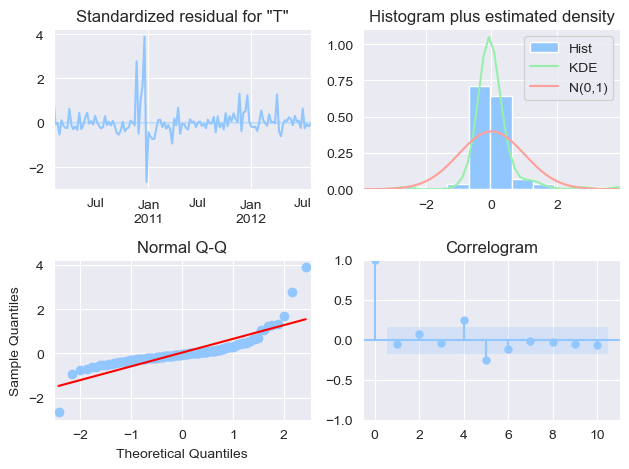

In [176]:
model = SARIMAX(train,  #model retraining
                order = (3,0,2),
                seasonal_order=(1,0,0,52),
                simple_differencing = False).fit()

plt.style.use('seaborn-pastel') #residual plot
model.plot_diagnostics()
plt.tight_layout()
plt.show()

In [177]:
## quantitative analysis for residual correlation

from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(model.resid, np.arange(1,11,1))


,lb_stat,lb_pvalue
1,0.126854,0.721716
2,0.288137,0.865829
3,0.755166,0.860158
4,3.043230,0.550617
5,6.024058,0.303885
6,6.764709,0.343156
7,6.916071,0.437671
8,6.966835,0.540215
9,7.154105,0.621078
10,7.598453,0.667994


-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for SARIMA forecast is : 0.0148
    Root Mean Squared Error for SARIMA forecast is : 846488.4748
    -------------------------------------------------------------------------------


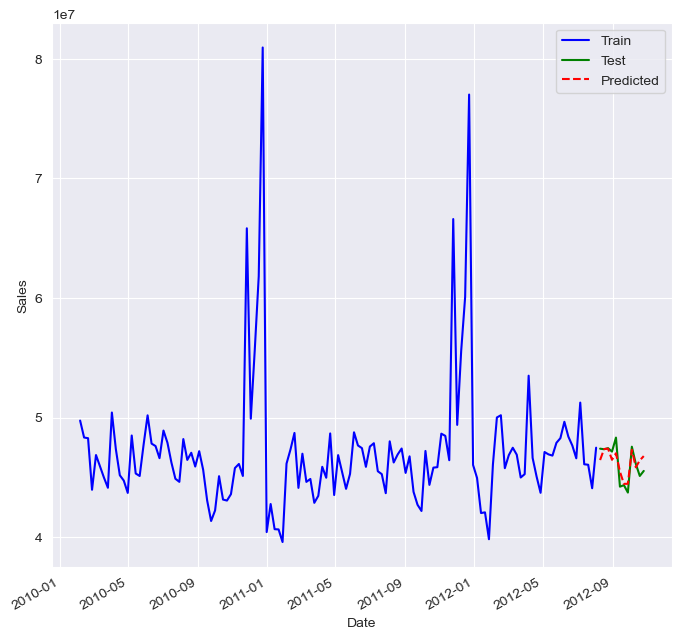

In [178]:
pred_f = model.get_forecast(steps = len(test))              #forecast for the 12 period
SARIMA_pred = pred_f.summary_frame(alpha = 0.05)['mean']    #capture the forecasted values
test.loc[:, 'SARIMA_pred'] = SARIMA_pred                    #add forecasted values to test dataframe

print_err('SARIMA_pred', 'SARIMA')                          #print errors based on forecasted values
plt_forecast('SARIMA_pred')                                 #plot train test and forecasted values

In [181]:
error_df

,pred_mean,last,ES_pred,DES_pred,TES_pred,ARMA_pred,SARIMA_pred
MAPE,3.006944e-02,3.216044e-02,2.955479e-02,3.097374e-02,0.015581,3.743209e-02,0.014850
RMSE,1.794183e+06,1.969609e+06,1.542179e+06,1.571983e+06,899961.837988,1.985110e+06,846488.474757


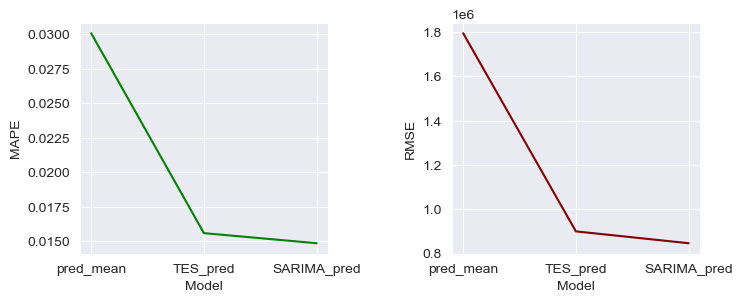

In [201]:
plt.subplots(figsize = (8,3))

plt.subplot(1,2,1)
plt.plot(error_df.loc['MAPE', ['pred_mean', 'TES_pred', 'SARIMA_pred']], color = 'green')
plt.xlabel('Model')
plt.ylabel("MAPE")

plt.subplot(1,2,2)
plt.plot(error_df.loc['RMSE', ['pred_mean', 'TES_pred', 'SARIMA_pred']], color = 'maroon')
plt.xlabel('Model')
plt.ylabel("RMSE")

plt.subplots_adjust(wspace = 0.5)

## Storewise Forecasting

In [104]:
df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year
Date,,,,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010


In [207]:
store_1 = df.loc[df['Store'] == 1] # creating seperate DataFrame for store 1

train1 = store_1.iloc[: -12, 1] #spliting stor 1 data into train
test1 = store_1.iloc[-12:, 1] #spliting stor 1 data into test

train1 = pd.DataFrame(data = train1) #saving data back to the train Dataframe 
test1 = pd.DataFrame(data = test1) #saving data back to the test Dataframe 

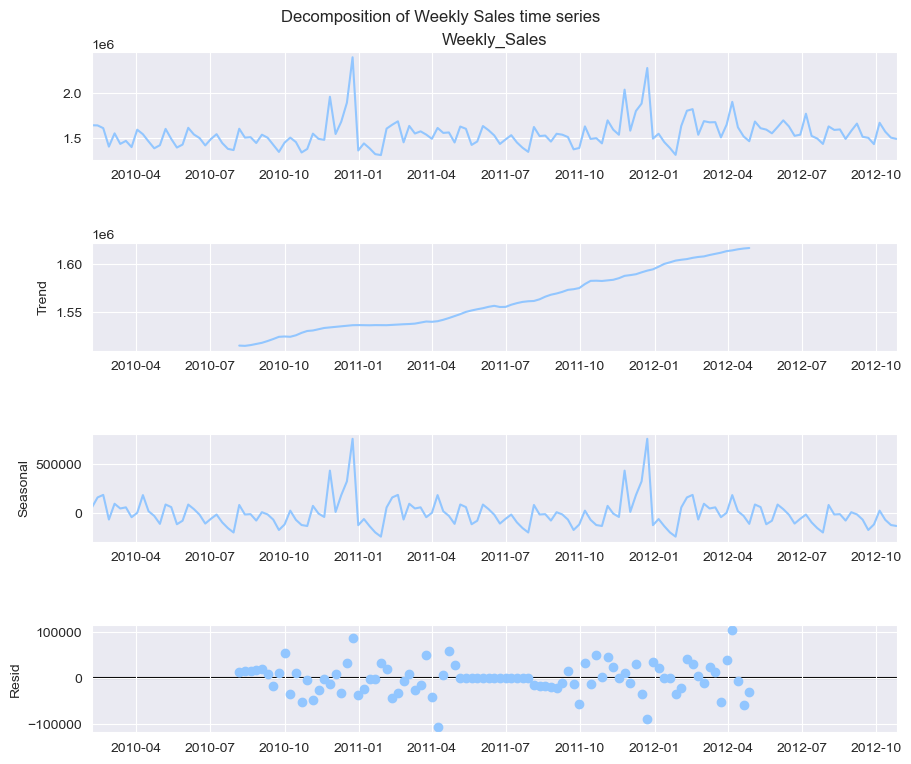

In [222]:
decompose1 = seasonal_decompose(store_1['Weekly_Sales'], model = 'additive', period = 52)
fig = decompose1.plot()
fig.set_figwidth(10)
fig.set_figheight(8)
fig.suptitle('Decomposition of Weekly Sales time series')
plt.show()

In [208]:
## implementing historical mean forecast.
historical_mean = np.mean(train1)
test1.loc[:, 'pred_mean_1'] = historical_mean.values[0]  ## seting a historical mean to pred_mean column


In [209]:
MAPE = mean_absolute_percentage_error(test1['Weekly_Sales'], test1['pred_mean_1'])
RMSE = np.sqrt(mean_squared_error(test1['Weekly_Sales'], test1['pred_mean_1']))


print(f"""-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Store1 forecast is : {MAPE:.4f}
    Root Mean Squared Error for store1 forecast is : {RMSE:.4f}
    -------------------------------------------------------------------------------""")

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Store1 forecast is : 0.0387
    Root Mean Squared Error for store1 forecast is : 68624.5866
    -------------------------------------------------------------------------------


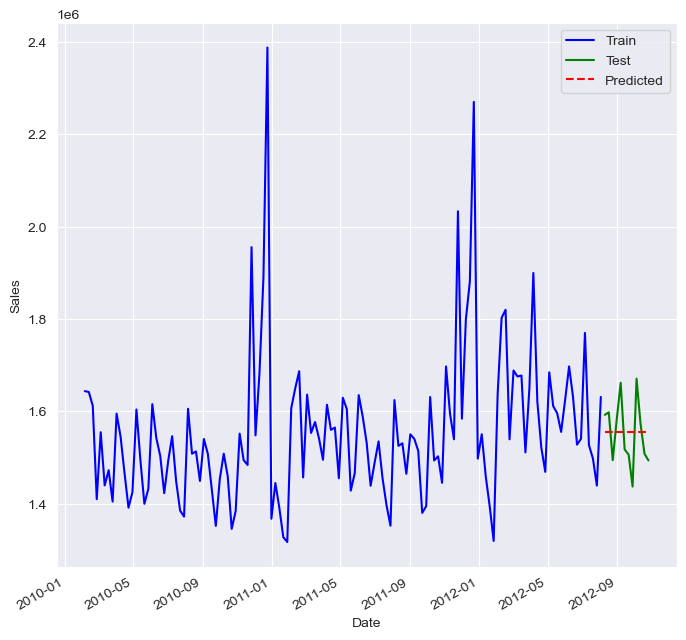

In [210]:
fig, ax = plt.subplots(figsize = (8,8))

ax.plot(train.index, train1['Weekly_Sales'], 'b-', label = 'Train')
ax.plot(test.index, test1['Weekly_Sales'], 'g-', label = 'Test')
ax.plot(test.index, test1['pred_mean_1'], 'r--', label = 'Predicted')
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
fig.autofmt_xdate()

In [211]:
from statsmodels.tsa.api import ExponentialSmoothing
TES_model = ExponentialSmoothing(train1, trend = 'additive',seasonal= 'additive').fit(optimized= True)
TES_pred = TES_model.forecast(steps = len(test1))
test1.loc[:, 'TES_pred'] = TES_pred


In [212]:
MAPE = mean_absolute_percentage_error(test1['Weekly_Sales'], test1['TES_pred'])
RMSE = np.sqrt(mean_squared_error(test1['Weekly_Sales'], test1['TES_pred']))


print(f"""-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Store1 forecast is : {MAPE:.4f}
    Root Mean Squared Error for store1 forecast is : {RMSE:.4f}
    -------------------------------------------------------------------------------""")

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Store1 forecast is : 0.0285
    Root Mean Squared Error for store1 forecast is : 54118.5502
    -------------------------------------------------------------------------------


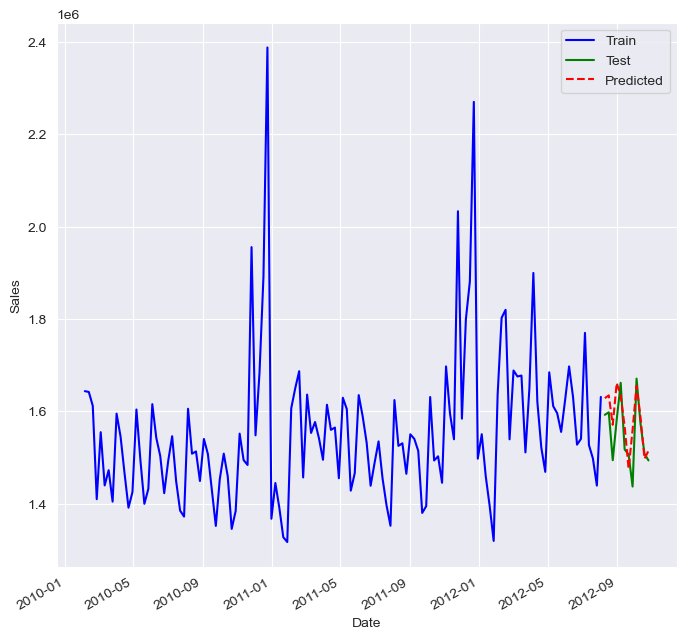

In [213]:
fig, ax = plt.subplots(figsize = (8,8))

ax.plot(train.index, train1['Weekly_Sales'], 'b-', label = 'Train')
ax.plot(test.index, test1['Weekly_Sales'], 'g-', label = 'Test')
ax.plot(test.index, test1['TES_pred'], 'r--', label = 'Predicted')
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
fig.autofmt_xdate()

In [214]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(train1)

print(f'ADF Statistic {ADF_result[0]}')
print(f'p-value {ADF_result[1]}')

ADF Statistic -4.9303983400746185
p-value 3.042172232917572e-05


In [215]:
ps = range(0,3) # try the values [] for p
qs = range(0,3) # try the values [] for p
Ps = range(0,3) # try the values [] for P
Qs = range(0,3) # try the values [] for Q

d = 0
D = 0
s = 52 # weekly data implies 52 as a frequency

order_ls = list(product(ps, qs, Ps, Qs)) ##Generate the unique combinations of orders.

results = []
for order in order_ls:
    model = SARIMAX(train1,
                   order = (order[0], d, order[1]),
                    seasonal_order= (order[2], D, order[3], s),
                   simple_differencing = False).fit()
    aic = model.aic
    #print([order, aic])
    results.append([order, aic])
    
    
results_df = pd.DataFrame(results, columns= ['(p,q, P, Q)', 'AIC']).sort_values(by = 'AIC').reset_index()
results_df

,index,"(p,q, P, Q)",AIC
0,75,"(2, 2, 1, 0)",3486.060818
1,66,"(2, 1, 1, 0)",3486.690760
2,39,"(1, 1, 1, 0)",3487.935584
3,76,"(2, 2, 1, 1)",3488.002493
4,78,"(2, 2, 2, 0)",3488.002559
...,...,...,...
76,17,"(0, 1, 2, 2)",4023.093011
77,9,"(0, 1, 0, 0)",4025.189732
78,0,"(0, 0, 0, 0)",4110.570805
79,2,"(0, 0, 0, 2)",4137.526701


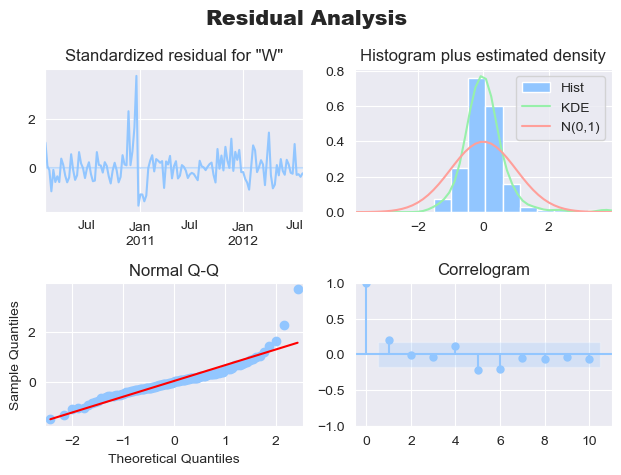

In [216]:
model = SARIMAX(train1, 
                order = (2,0,2),
                seasonal_order=(1,0,0,52),
                simple_differencing = False).fit()

plt.style.use('seaborn-pastel')
model.plot_diagnostics()
plt.suptitle('Residual Analysis', weight = 'black', fontsize = 15)
plt.tight_layout()
plt.show()

In [217]:
pred_f = model.get_forecast(steps = len(test1))
SARIMA_pred = pred_f.summary_frame(alpha = 0.05)['mean']
test1.loc[:, 'SARIMA_pred'] = SARIMA_pred
test1.head()

,Weekly_Sales,pred_mean_1,TES_pred,SARIMA_pred
Date,,,,
2012-08-10,1592409.97,1.555484e+06,1.628499e+06,1.590178e+06
2012-08-17,1597868.05,1.555484e+06,1.634518e+06,1.601427e+06
2012-08-24,1494122.38,1.555484e+06,1.570873e+06,1.551967e+06
2012-08-31,1582083.40,1.555484e+06,1.661449e+06,1.612663e+06
2012-09-07,1661767.33,1.555484e+06,1.633779e+06,1.598110e+06


In [218]:
MAPE = mean_absolute_percentage_error(test1['Weekly_Sales'], test1['SARIMA_pred'])
RMSE = np.sqrt(mean_squared_error(test1['Weekly_Sales'], test1['SARIMA_pred']))


print(f"""-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Store1 forecast is : {MAPE:.4f}
    Root Mean Squared Error for store1 forecast is : {RMSE:.4f}
    -------------------------------------------------------------------------------""")

-------------------------------------------------------------------------------
    Mean Absolue Percentage Error for Store1 forecast is : 0.0246
    Root Mean Squared Error for store1 forecast is : 47149.4948
    -------------------------------------------------------------------------------


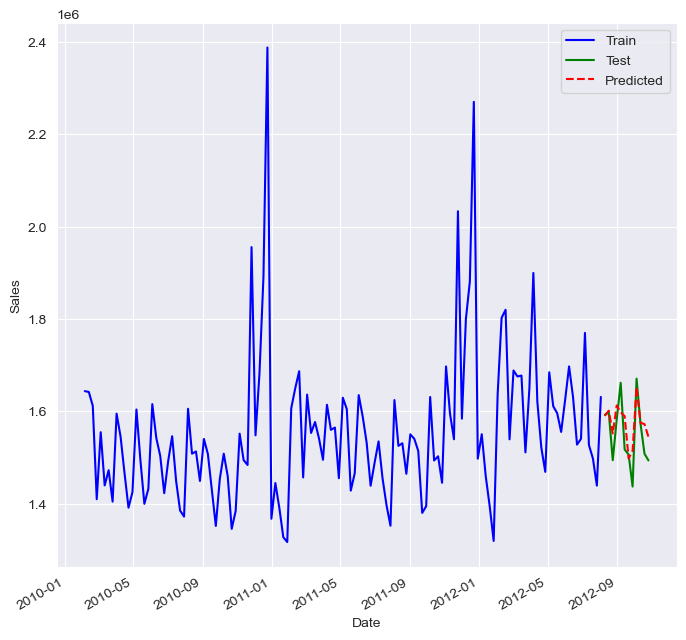

In [219]:
fig, ax = plt.subplots(figsize = (8,8))

ax.plot(train.index, train1['Weekly_Sales'], 'b-', label = 'Train')
ax.plot(test.index, test1['Weekly_Sales'], 'g-', label = 'Test')
ax.plot(test.index, test1['SARIMA_pred'], 'r--', label = 'Predicted')
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend()
fig.autofmt_xdate()